In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import acquire
import summarize as s
import prepare
from env import username as u, password as p, host as h, url
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import wrangle_zillow as w

#### Acquire and Summarize

Acquire data from the cloud database.

You will want to end with a single dataframe. Include the logerror field and all other fields related to the properties that are available. You will end up using all the tables in the database.

Be sure to do the correct join (inner, outer, etc.). We do not want to eliminate properties purely because they may have a null value for airconditioningtypeid. 

    - Only include properties with a transaction in 2017, and include only the last transaction for each property (so no duplicate property ID's), along with zestimate error and date of transaction. (Hint: read the docs for the .duplicated method) 
    - Only include properties that have a latitude and longitude value.

In [2]:
def get_zillow_2017():
    '''
    get_sql_url will pull the credentials present from any current env
    file in the same directory as this acquire script
    and will return a connection based on what schema and databases 
    (db) are handed to the function call
    '''

    query ='''
    select * from 
        (
            select * from 
            properties_2017 
            left join propertylandusetype 
            using (propertylandusetypeid)
            left join airconditioningtype
            using (airconditioningtypeid) 
            left join architecturalstyletype
            using (architecturalstyletypeid)
            left join buildingclasstype
            using (buildingclasstypeid)
            left join heatingorsystemtype
            using(heatingorsystemtypeid)
            left join storytype
            using (storytypeid)
            left join typeconstructiontype
            using (typeconstructiontypeid)
        ) as z
        join predictions_2017 as y using (parcelid);
    '''
    
    if os.path.isfile('zillow_2017.csv'):

        df = pd.read_csv('zillow_2017.csv')
    
    else:

        url = f'mysql+pymysql://{u}:{p}@{h}/zillow'

        df = pd.read_sql(f'{query}', url)

        df.to_csv('zillow_2017.csv')
        
    query2 ='''
    select * from unique_properties;
    '''
    
    if os.path.isfile('unique_properties.csv'):

        unique_df = pd.read_csv('unique_properties.csv')
    
    else:

        url = f'mysql+pymysql://{u}:{p}@{h}/zillow'

        unique_df = pd.read_sql(f'{query2}', url)

        unique_df.to_csv('unique_properties.csv')
        
    unique_df.drop(columns='Unnamed: 0', inplace=True)
    unique_df['unique'] = 'unique'
    
    zillow = df.merge(unique_df, how='left', on='parcelid')
    
    zillow.drop(columns='Unnamed: 0', inplace=True)
    
    zillow = zillow.sort_values(by='transactiondate', ascending=False)
    
    zillow = zillow.drop_duplicates(subset=['parcelid'], keep='first')
    
    zillow = zillow[(zillow['latitude'].isna() == False) | (zillow['longitude'].isna() == False)]
    
    return zillow


In [3]:
df = get_zillow_2017()
df

,parcelid,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,propertylandusetypeid,id,basementsqft,...,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc,id.1,logerror,transactiondate,unique
77613,13083743,NaN,NaN,7.00,NaN,NaN,NaN,261.00,2455685,NaN,...,NaN,NaN,NaN,Floor/Wall,NaN,NaN,77613,-0.20,2018-05-25,unique
77612,12826780,NaN,NaN,2.00,NaN,NaN,NaN,261.00,1187175,NaN,...,NaN,NaN,NaN,Central,NaN,NaN,77612,0.01,2017-09-25,unique
77611,12773139,NaN,NaN,2.00,NaN,NaN,1.00,261.00,1843709,NaN,...,Central,NaN,NaN,Central,NaN,NaN,77611,0.04,2017-09-21,unique
77610,17239384,NaN,NaN,NaN,NaN,NaN,NaN,261.00,2968375,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77610,0.01,2017-09-21,unique
77609,11000655,NaN,NaN,2.00,NaN,NaN,NaN,261.00,673515,NaN,...,NaN,NaN,NaN,Central,NaN,NaN,77609,0.02,2017-09-20,unique
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,17143294,NaN,NaN,NaN,NaN,NaN,NaN,266.00,1447245,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,-0.02,2017-01-01,unique
4,10887214,NaN,NaN,2.00,NaN,NaN,1.00,266.00,1970746,NaN,...,Central,NaN,NaN,Central,NaN,NaN,4,0.01,2017-01-01,unique
3,12177905,NaN,NaN,2.00,NaN,NaN,NaN,261.00,2288172,NaN,...,NaN,NaN,NaN,Central,NaN,NaN,3,-0.10,2017-01-01,unique
2,14186244,NaN,NaN,NaN,NaN,NaN,NaN,261.00,11677,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0.01,2017-01-01,unique


2. Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

3. Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.

In [4]:
def nulls_by_row(df):
    '''
    This function takes in a dataframe 
    and finds the number of missing values in a row
    it returns a new dataframe with quantity and percent of missing values
    '''
    num_missing = df.isnull().sum(axis=1)
    percent_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': percent_miss})
    rows_missing = df.merge(rows_missing,
                        left_index=True,
                        right_index=True)[['num_cols_missing', 'percent_cols_missing']]
    return rows_missing.sort_values(by='num_cols_missing', ascending=False)

In [5]:
def nulls_by_col(df):
    '''
    This function takes in a dataframe 
    and finds the number of missing values
    it returns a new dataframe with quantity and percent of missing values
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    percent_missing = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': percent_missing})
    return cols_missing.sort_values(by='num_rows_missing', ascending=False)

In [6]:
# def summarize(df):
#     '''
#     summarize will take in a single argument (a pandas dataframe) 
#     and output to console various statistics on said dataframe, including:
#     # .head()
#     # .info()
#     # .describe()
#     # .value_counts()
#     # observation of nulls in the dataframe
#     '''
#     print('                    SUMMARY REPORT')
#     print('=====================================================\n\n')
#     print('Dataframe head: ')
#     display(pd.DataFrame(df.head(3)))
#     print('=====================================================\n\n')
#     print('Dataframe info: ')
#     display(pd.DataFrame(df.info()))
#     print('=====================================================\n\n')
#     print('Dataframe Description: ')
#     display(pd.DataFrame(df.describe()))
#     num_cols = [col for col in df.columns if df[col].dtype != 'O']
#     cat_cols = [col for col in df.columns if col not in num_cols]
#     print('=====================================================')
#     print('DataFrame value counts: ')
#     for col in df.columns:
#         if col in cat_cols:
#             display(pd.DataFrame(df[col].value_counts()))
#         else:
#             display(pd.DataFrame(df[col].value_counts(bins=10, sort=False)))
#     print('=====================================================')
#     print('nulls in dataframe by column: ')
#     display(pd.DataFrame(nulls_by_col(df)))
#     print('=====================================================')
#     print('nulls in dataframe by row: ')
#     display(pd.DataFrame(nulls_by_row(df)))
#     print('=====================================================')

['parcelid', 'typeconstructiontypeid', 'storytypeid', 'heatingorsystemtypeid', 'buildingclasstypeid', 'architecturalstyletypeid', 'airconditioningtypeid', 'propertylandusetypeid', 'id', 'buildingqualitytypeid', 'decktypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'id.1']

#### Prepare

1. Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer.

In [7]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52320
Condominium                                   19294
Duplex (2 Units, Any Combination)              2009
Planned Unit Development                       1944
Quadruplex (4 Units, Any Combination)           727
Triplex (3 Units, Any Combination)              535
Cluster Home                                    333
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       58
Residential General                              37
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

In [8]:
df = df[(df['propertylandusedesc'] != 'Duplex (2 Units, Any Combination)') & (df['propertylandusedesc'] != 'Planned Unit Development') & (df['propertylandusedesc'] != 'Quadruplex (4 Units, Any Combination)') & (df['propertylandusedesc'] != 'Triplex (3 Units, Any Combination)') & (df['propertylandusedesc'] != 'Cluster Home') & (df['propertylandusedesc'] != 'Commercial/Office/Residential Mixed Used')] 

In [9]:
def remove_columns(df, cols_to_remove):
    '''
    This function takes in a dataframe 
    and the columns that need to be dropped
    then returns the desired dataframe.
    '''
    df = df.drop(columns=cols_to_remove)
    return df

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcelid,"71,818.00","13,043,520.82","3,393,909.43","10,711,855.00","11,537,979.25","12,574,479.00","14,255,012.50","167,688,532.00"
typeconstructiontypeid,222.00,6.04,0.56,4.00,6.00,6.00,6.00,13.00
storytypeid,47.00,7.00,0.00,7.00,7.00,7.00,7.00,7.00
heatingorsystemtypeid,"46,600.00",3.95,3.65,1.00,2.00,2.00,7.00,24.00
buildingclasstypeid,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,206.00,7.39,2.73,2.00,7.00,7.00,7.00,21.00
airconditioningtypeid,"23,035.00",1.87,3.06,1.00,1.00,1.00,1.00,13.00
propertylandusetypeid,"71,818.00",262.36,2.25,260.00,261.00,261.00,266.00,275.00
id,"71,818.00","1,495,244.26","860,494.61",349.00,"753,863.75","1,499,059.00","2,239,543.50","2,982,274.00"
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"


In [11]:
df['typeconstructiontypeid'].value_counts()

 6.00    219
 4.00      1
10.00      1
13.00      1
Name: typeconstructiontypeid, dtype: int64

In [12]:
cols = df.columns.to_list()
cols

['parcelid',
 'typeconstructiontypeid',
 'storytypeid',
 'heatingorsystemtypeid',
 'buildingclasstypeid',
 'architecturalstyletypeid',
 'airconditioningtypeid',
 'propertylandusetypeid',
 'id',
 'basementsqft',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fips',
 'fireplacecnt',
 'fullbathcnt',
 'garagecarcnt',
 'garagetotalsqft',
 'hashottuborspa',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidneighborhood',
 'regionidzip',
 'roomcnt',
 'threequarterbathnbr',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'yearbuilt',
 'numberofstories',


In [13]:
def remove_ids(df):
    id_cols = []
    for col in cols:
        r = 'id'
        if r in col:
            id_cols.append(col)
            df = df.drop(columns=col)
    print(id_cols)
    return df

In [14]:
df = remove_ids(df)

['parcelid', 'typeconstructiontypeid', 'storytypeid', 'heatingorsystemtypeid', 'buildingclasstypeid', 'architecturalstyletypeid', 'airconditioningtypeid', 'propertylandusetypeid', 'id', 'buildingqualitytypeid', 'decktypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'id.1']


In [15]:
len(df.columns)

51

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"71,818.00",2.26,0.96,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"71,818.00",3.00,1.03,0.00,2.00,3.00,4.00,14.00
calculatedbathnbr,"71,547.00",2.27,0.95,1.00,2.00,2.00,3.00,18.00
finishedfloor1squarefeet,"5,688.00","1,386.54",680.24,44.00,968.00,"1,275.00","1,632.00","6,912.00"
calculatedfinishedsquarefeet,"71,630.00","1,751.80",933.90,128.00,"1,164.00","1,512.00","2,065.00","21,929.00"
finishedsquarefeet12,"71,411.00","1,753.34",934.11,128.00,"1,165.00","1,514.00","2,068.00","21,929.00"
finishedsquarefeet13,41.00,"1,389.85",123.53,"1,056.00","1,344.00","1,440.00","1,440.00","1,560.00"
finishedsquarefeet15,11.00,756.27,199.48,598.00,608.00,654.00,818.50,"1,182.00"
finishedsquarefeet50,"5,688.00","1,402.70",737.37,44.00,971.00,"1,278.00","1,637.00","12,467.00"


In [17]:
s.summarize(df)

                    SUMMARY REPORT


Dataframe head: 


,basementsqft,bathroomcnt,bedroomcnt,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,...,propertylandusedesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc,logerror,transactiondate,unique
77613,NaN,2.00,3.00,2.00,NaN,"1,050.00","1,050.00",NaN,NaN,NaN,...,Single Family Residential,NaN,NaN,NaN,Floor/Wall,NaN,NaN,-0.20,2018-05-25,unique
77612,NaN,2.00,3.00,2.00,NaN,"1,762.00","1,762.00",NaN,NaN,NaN,...,Single Family Residential,NaN,NaN,NaN,Central,NaN,NaN,0.01,2017-09-25,unique
77611,NaN,1.00,3.00,1.00,NaN,"1,032.00","1,032.00",NaN,NaN,NaN,...,Single Family Residential,Central,NaN,NaN,Central,NaN,NaN,0.04,2017-09-21,unique




Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71818 entries, 77613 to 0
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   basementsqft                  47 non-null     float64
 1   bathroomcnt                   71818 non-null  float64
 2   bedroomcnt                    71818 non-null  float64
 3   calculatedbathnbr             71547 non-null  float64
 4   finishedfloor1squarefeet      5688 non-null   float64
 5   calculatedfinishedsquarefeet  71630 non-null  float64
 6   finishedsquarefeet12          71411 non-null  float64
 7   finishedsquarefeet13          41 non-null     float64
 8   finishedsquarefeet15          11 non-null     float64
 9   finishedsquarefeet50          5688 non-null   float64
 10  finishedsquarefeet6           167 non-null    float64
 11  fips                          71818 non-null  float64
 12  fireplacecnt                  8092 non-nu

""




Dataframe Description: 


,count,mean,std,min,25%,50%,75%,max
basementsqft,47.00,678.98,711.83,38.00,263.50,512.00,809.50,"3,560.00"
bathroomcnt,"71,818.00",2.26,0.96,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"71,818.00",3.00,1.03,0.00,2.00,3.00,4.00,14.00
calculatedbathnbr,"71,547.00",2.27,0.95,1.00,2.00,2.00,3.00,18.00
finishedfloor1squarefeet,"5,688.00","1,386.54",680.24,44.00,968.00,"1,275.00","1,632.00","6,912.00"
calculatedfinishedsquarefeet,"71,630.00","1,751.80",933.90,128.00,"1,164.00","1,512.00","2,065.00","21,929.00"
finishedsquarefeet12,"71,411.00","1,753.34",934.11,128.00,"1,165.00","1,514.00","2,068.00","21,929.00"
finishedsquarefeet13,41.00,"1,389.85",123.53,"1,056.00","1,344.00","1,440.00","1,440.00","1,560.00"
finishedsquarefeet15,11.00,756.27,199.48,598.00,608.00,654.00,818.50,"1,182.00"
finishedsquarefeet50,"5,688.00","1,402.70",737.37,44.00,971.00,"1,278.00","1,637.00","12,467.00"


DataFrame value counts: 


,basementsqft
"(34.477000000000004, 390.2]",20
"(390.2, 742.4]",13
"(742.4, 1094.6]",7
"(1094.6, 1446.8]",3
"(1446.8, 1799.0]",0
"(1799.0, 2151.2]",2
"(2151.2, 2503.4]",0
"(2503.4, 2855.6]",0
"(2855.6, 3207.8]",1
"(3207.8, 3560.0]",1


,bathroomcnt
"(-0.019, 1.8]",14424
"(1.8, 3.6]",52604
"(3.6, 5.4]",4010
"(5.4, 7.2]",685
"(7.2, 9.0]",85
"(9.0, 10.8]",5
"(10.8, 12.6]",3
"(12.6, 14.4]",1
"(14.4, 16.2]",0
"(16.2, 18.0]",1


,bedroomcnt
"(-0.015, 1.4]",3819
"(1.4, 2.8]",18410
"(2.8, 4.2]",44821
"(4.2, 5.6]",3989
"(5.6, 7.0]",740
"(7.0, 8.4]",25
"(8.4, 9.8]",8
"(9.8, 11.2]",4
"(11.2, 12.6]",1
"(12.6, 14.0]",1


,calculatedbathnbr
"(0.982, 2.7]",50383
"(2.7, 4.4]",18866
"(4.4, 6.1]",2067
"(6.1, 7.8]",152
"(7.8, 9.5]",69
"(9.5, 11.2]",8
"(11.2, 12.9]",0
"(12.9, 14.6]",1
"(14.6, 16.3]",0
"(16.3, 18.0]",1


,finishedfloor1squarefeet
"(37.131, 730.8]",627
"(730.8, 1417.6]",2827
"(1417.6, 2104.4]",1671
"(2104.4, 2791.2]",336
"(2791.2, 3478.0]",136
"(3478.0, 4164.8]",43
"(4164.8, 4851.6]",26
"(4851.6, 5538.4]",12
"(5538.4, 6225.2]",6
"(6225.2, 6912.0]",4


,calculatedfinishedsquarefeet
"(106.198, 2308.1]",58022
"(2308.1, 4488.2]",12375
"(4488.2, 6668.3]",1013
"(6668.3, 8848.4]",158
"(8848.4, 11028.5]",43
"(11028.5, 13208.6]",12
"(13208.6, 15388.7]",2
"(15388.7, 17568.8]",2
"(17568.8, 19748.9]",1
"(19748.9, 21929.0]",2


,finishedsquarefeet12
"(106.198, 2308.1]",57820
"(2308.1, 4488.2]",12359
"(4488.2, 6668.3]",1012
"(6668.3, 8848.4]",158
"(8848.4, 11028.5]",43
"(11028.5, 13208.6]",12
"(13208.6, 15388.7]",2
"(15388.7, 17568.8]",2
"(17568.8, 19748.9]",1
"(19748.9, 21929.0]",2


,finishedsquarefeet13
"(1055.4950000000001, 1106.4]",2
"(1106.4, 1156.8]",2
"(1156.8, 1207.2]",1
"(1207.2, 1257.6]",2
"(1257.6, 1308.0]",1
"(1308.0, 1358.4]",5
"(1358.4, 1408.8]",2
"(1408.8, 1459.2]",18
"(1459.2, 1509.6]",3
"(1509.6, 1560.0]",5


,finishedsquarefeet15
"(597.4150000000001, 656.4]",6
"(656.4, 714.8]",0
"(714.8, 773.2]",2
"(773.2, 831.6]",0
"(831.6, 890.0]",0
"(890.0, 948.4]",1
"(948.4, 1006.8]",0
"(1006.8, 1065.2]",1
"(1065.2, 1123.6]",0
"(1123.6, 1182.0]",1


,finishedsquarefeet50
"(31.576, 1286.3]",2880
"(1286.3, 2528.6]",2475
"(2528.6, 3770.9]",243
"(3770.9, 5013.2]",62
"(5013.2, 6255.5]",17
"(6255.5, 7497.8]",7
"(7497.8, 8740.1]",2
"(8740.1, 9982.4]",1
"(9982.4, 11224.7]",0
"(11224.7, 12467.0]",1


,finishedsquarefeet6
"(374.781, 901.8]",58
"(901.8, 1423.6]",72
"(1423.6, 1945.4]",16
"(1945.4, 2467.2]",8
"(2467.2, 2989.0]",4
"(2989.0, 3510.8]",4
"(3510.8, 4032.6]",2
"(4032.6, 4554.4]",2
"(4554.4, 5076.2]",0
"(5076.2, 5598.0]",1


,fips
"(6036.925, 6044.4]",45618
"(6044.4, 6051.8]",0
"(6051.8, 6059.2]",20369
"(6059.2, 6066.6]",0
"(6066.6, 6074.0]",0
"(6074.0, 6081.4]",0
"(6081.4, 6088.8]",0
"(6088.8, 6096.2]",0
"(6096.2, 6103.6]",0
"(6103.6, 6111.0]",5831


,fireplacecnt
"(0.995, 1.4]",6831
"(1.4, 1.8]",0
"(1.8, 2.2]",990
"(2.2, 2.6]",0
"(2.6, 3.0]",233
"(3.0, 3.4]",0
"(3.4, 3.8]",0
"(3.8, 4.2]",35
"(4.2, 4.6]",0
"(4.6, 5.0]",3


,fullbathcnt
"(0.982, 2.7]",50400
"(2.7, 4.4]",19565
"(4.4, 6.1]",1406
"(6.1, 7.8]",97
"(7.8, 9.5]",69
"(9.5, 11.2]",8
"(11.2, 12.9]",0
"(12.9, 14.6]",1
"(14.6, 16.3]",0
"(16.3, 18.0]",1


,garagecarcnt
"(-0.015, 1.4]",5613
"(1.4, 2.8]",18390
"(2.8, 4.2]",887
"(4.2, 5.6]",45
"(5.6, 7.0]",18
"(7.0, 8.4]",2
"(8.4, 9.8]",2
"(9.8, 11.2]",4
"(11.2, 12.6]",0
"(12.6, 14.0]",2


,garagetotalsqft
"(-4.252000000000001, 425.1]",11426
"(425.1, 850.2]",13160
"(850.2, 1275.3]",323
"(1275.3, 1700.4]",38
"(1700.4, 2125.5]",6
"(2125.5, 2550.6]",2
"(2550.6, 2975.7]",4
"(2975.7, 3400.8]",2
"(3400.8, 3825.9]",1
"(3825.9, 4251.0]",1


,hashottuborspa
"(0.9989, 0.9992]",0
"(0.9992, 0.9994]",0
"(0.9994, 0.9996]",0
"(0.9996, 0.9998]",0
"(0.9998, 1.0]",1537
"(1.0, 1.0002]",0
"(1.0002, 1.0004]",0
"(1.0004, 1.0006]",0
"(1.0006, 1.0008]",0
"(1.0008, 1.001]",0


,latitude
"(33338047.759000003, 33487451.0]",1011
"(33487451.0, 33635375.0]",5267
"(33635375.0, 33783299.0]",9668
"(33783299.0, 33931223.0]",13954
"(33931223.0, 34079147.0]",12331
"(34079147.0, 34227071.0]",17362
"(34227071.0, 34374995.0]",5966
"(34374995.0, 34522919.0]",2675
"(34522919.0, 34670843.0]",2284
"(34670843.0, 34818767.0]",1300


,longitude
"(-119477336.781, -119283338.0]",199
"(-119283338.0, -119091260.0]",1865
"(-119091260.0, -118899182.0]",1339
"(-118899182.0, -118707104.0]",2388
"(-118707104.0, -118515026.0]",5372
"(-118515026.0, -118322948.0]",14394
"(-118322948.0, -118130870.0]",13293
"(-118130870.0, -117938792.0]",13416
"(-117938792.0, -117746714.0]",12286
"(-117746714.0, -117554636.0]",7266


,lotsizesquarefeet
"(-6734.775000000001, 697313.4]",63412
"(697313.4, 1394390.8]",221
"(1394390.8, 2091468.2]",39
"(2091468.2, 2788545.6]",2
"(2788545.6, 3485623.0]",1
"(3485623.0, 4182700.4]",9
"(4182700.4, 4879777.8]",0
"(4879777.8, 5576855.2]",0
"(5576855.2, 6273932.6]",0
"(6273932.6, 6971010.0]",7


,poolcnt
"(0.9989, 0.9992]",0
"(0.9992, 0.9994]",0
"(0.9994, 0.9996]",0
"(0.9996, 0.9998]",0
"(0.9998, 1.0]",15730
"(1.0, 1.0002]",0
"(1.0002, 1.0004]",0
"(1.0004, 1.0006]",0
"(1.0006, 1.0008]",0
"(1.0008, 1.001]",0


,poolsizesum
"(22.523, 171.6]",7
"(171.6, 319.2]",47
"(319.2, 466.8]",322
"(466.8, 614.4]",306
"(614.4, 762.0]",123
"(762.0, 909.6]",48
"(909.6, 1057.2]",7
"(1057.2, 1204.8]",5
"(1204.8, 1352.4]",0
"(1352.4, 1500.0]",2


,propertycountylandusecode
0100,26714
122,13045
010C,8813
0101,6399
34,4922
1111,3353
1,2392
010E,2047
1129,1378
1110,1024


,propertyzoningdesc
LAR1,6520
LAR3,2250
LARS,1380
LBR1N,1136
LARD1.5,869
...,...
PDR17*,1
WCOP*,1
LRA12*,1
SRR111000*,1


,rawcensustractandblock
"(60370272.019999996, 60444919.091]",45618
"(60444919.091, 60518827.081]",0
"(60518827.081, 60592735.071]",20369
"(60592735.071, 60666643.061]",0
"(60666643.061, 60740551.052]",0
"(60740551.052, 60814459.042]",0
"(60814459.042, 60888367.032]",0
"(60888367.032, 60962275.022]",0
"(60962275.022, 61036183.012]",0
"(61036183.012, 61110091.002]",5831


,roomcnt
"(-0.016, 1.5]",54600
"(1.5, 3.0]",219
"(3.0, 4.5]",1305
"(4.5, 6.0]",7324
"(6.0, 7.5]",3815
"(7.5, 9.0]",4056
"(9.0, 10.5]",339
"(10.5, 12.0]",143
"(12.0, 13.5]",10
"(13.5, 15.0]",7


,threequarterbathnbr
"(0.993, 1.6]",9905
"(1.6, 2.2]",75
"(2.2, 2.8]",0
"(2.8, 3.4]",8
"(3.4, 4.0]",0
"(4.0, 4.6]",0
"(4.6, 5.2]",0
"(5.2, 5.8]",0
"(5.8, 6.4]",0
"(6.4, 7.0]",1


,unitcnt
"(0.994, 1.5]",45326
"(1.5, 2.0]",33
"(2.0, 2.5]",0
"(2.5, 3.0]",3
"(3.0, 3.5]",0
"(3.5, 4.0]",2
"(4.0, 4.5]",0
"(4.5, 5.0]",0
"(5.0, 5.5]",0
"(5.5, 6.0]",1


,yardbuildingsqft17
"(7.819, 329.0]",1523
"(329.0, 647.0]",594
"(647.0, 965.0]",95
"(965.0, 1283.0]",34
"(1283.0, 1601.0]",9
"(1601.0, 1919.0]",1
"(1919.0, 2237.0]",2
"(2237.0, 2555.0]",2
"(2555.0, 2873.0]",1
"(2873.0, 3191.0]",2


,yardbuildingsqft26
"(11.143, 97.6]",24
"(97.6, 183.2]",14
"(183.2, 268.8]",10
"(268.8, 354.4]",7
"(354.4, 440.0]",4
"(440.0, 525.6]",6
"(525.6, 611.2]",2
"(611.2, 696.8]",1
"(696.8, 782.4]",1
"(782.4, 868.0]",1


,yearbuilt
"(1877.861, 1891.8]",22
"(1891.8, 1905.6]",169
"(1905.6, 1919.4]",1045
"(1919.4, 1933.2]",4191
"(1933.2, 1947.0]",4914
"(1947.0, 1960.8]",16123
"(1960.8, 1974.6]",14367
"(1974.6, 1988.4]",14692
"(1988.4, 2002.2]",9851
"(2002.2, 2016.0]",6223


,numberofstories
"(0.994, 1.5]",10146
"(1.5, 2.0]",6439
"(2.0, 2.5]",0
"(2.5, 3.0]",427
"(3.0, 3.5]",0
"(3.5, 4.0]",0
"(4.0, 4.5]",0
"(4.5, 5.0]",0
"(5.0, 5.5]",0
"(5.5, 6.0]",1


,fireplaceflag
"(0.9989, 0.9992]",0
"(0.9992, 0.9994]",0
"(0.9994, 0.9996]",0
"(0.9996, 0.9998]",0
"(0.9998, 1.0]",172
"(1.0, 1.0002]",0
"(1.0002, 1.0004]",0
"(1.0004, 1.0006]",0
"(1.0006, 1.0008]",0
"(1.0008, 1.001]",0


,structuretaxvaluedollarcnt
"(-11377.747, 1142218.6]",71136
"(1142218.6, 2284393.2]",469
"(2284393.2, 3426567.8]",73
"(3426567.8, 4568742.4]",19
"(4568742.4, 5710917.0]",9
"(5710917.0, 6853091.6]",2
"(6853091.6, 7995266.2]",6
"(7995266.2, 9137440.8]",0
"(9137440.8, 10279615.4]",1
"(10279615.4, 11421790.0]",1


,taxvaluedollarcnt
"(-48060.236999999994, 4907023.6]",71597
"(4907023.6, 9813047.2]",181
"(9813047.2, 14719070.8]",25
"(14719070.8, 19625094.4]",8
"(19625094.4, 24531118.0]",4
"(24531118.0, 29437141.6]",1
"(29437141.6, 34343165.2]",0
"(34343165.2, 39249188.8]",0
"(39249188.8, 44155212.4]",0
"(44155212.4, 49061236.0]",1


,assessmentyear
"(2013.983, 2014.387]",0
"(2014.387, 2014.79]",0
"(2014.79, 2015.194]",0
"(2015.194, 2015.597]",0
"(2015.597, 2016.0]",71818
"(2016.0, 2016.403]",0
"(2016.403, 2016.806]",0
"(2016.806, 2017.21]",0
"(2017.21, 2017.613]",0
"(2017.613, 2018.016]",0


,landtaxvaluedollarcnt
"(-48791.03799999999, 4895364.7]",71708
"(4895364.7, 9790568.4]",88
"(9790568.4, 14685772.1]",13
"(14685772.1, 19580975.8]",5
"(19580975.8, 24476179.5]",1
"(24476179.5, 29371383.2]",0
"(29371383.2, 34266586.9]",0
"(34266586.9, 39161790.6]",0
"(39161790.6, 44056994.3]",0
"(44056994.3, 48952198.0]",1


,taxamount
"(-566.6999999999999, 58681.858]",71603
"(58681.858, 117343.796]",175
"(117343.796, 176005.734]",21
"(176005.734, 234667.672]",9
"(234667.672, 293329.61]",4
"(293329.61, 351991.548]",0
"(351991.548, 410653.486]",0
"(410653.486, 469315.424]",0
"(469315.424, 527977.362]",0
"(527977.362, 586639.3]",1


,taxdelinquencyflag
Y,2605


,taxdelinquencyyear
"(3.904, 13.5]",474
"(13.5, 23.0]",2130
"(23.0, 32.5]",0
"(32.5, 42.0]",0
"(42.0, 51.5]",0
"(51.5, 61.0]",0
"(61.0, 70.5]",0
"(70.5, 80.0]",0
"(80.0, 89.5]",0
"(89.5, 99.0]",1


,censustractandblock
"(59948352007016.984, 102636920499301.5]",71588
"(102636920499301.5, 144902829897603.0]",0
"(144902829897603.0, 187168739295904.5]",0
"(187168739295904.5, 229434648694206.03]",0
"(229434648694206.03, 271700558092507.5]",0
"(271700558092507.5, 313966467490809.0]",0
"(313966467490809.0, 356232376889110.5]",0
"(356232376889110.5, 398498286287411.94]",0
"(398498286287411.94, 440764195685713.5]",0
"(440764195685713.5, 483030105084015.0]",1


,propertylandusedesc
Single Family Residential,52320
Condominium,19294
Mobile Home,74
"Manufactured, Modular, Prefabricated Homes",58
Residential General,37
Cooperative,29
Townhouse,6


,airconditioningdesc
Central,21248
Yes,1567
None,167
Wall Unit,53


,architecturalstyledesc
Contemporary,172
Conventional,19
Ranch/Rambler,7
Bungalow,5
Cape Cod,3


,buildingclassdesc


,heatingorsystemdesc
Central,31512
Floor/Wall,13266
Yes,846
Forced air,776
Solar,101
None,59
Radiant,23
Baseboard,13
Gravity,3
Heat Pump,1


,storydesc
Basement,47


,typeconstructiondesc
Frame,219
Concrete,1
Metal,1
Masonry,1


,logerror
"(-4.666, -3.664]",3
"(-3.664, -2.672]",1
"(-2.672, -1.68]",35
"(-1.68, -0.688]",128
"(-0.688, 0.304]",69983
"(0.304, 1.296]",1504
"(1.296, 2.287]",94
"(2.287, 3.279]",68
"(3.279, 4.271]",1
"(4.271, 5.263]",1


,transactiondate
2017-06-30,1089
2017-04-28,837
2017-05-31,795
2017-07-28,750
2017-08-31,713
...,...
2017-07-08,1
2017-08-13,1
2017-08-12,1
2017-08-06,1


,unique
unique,71818


nulls in dataframe by column: 


,num_rows_missing,percent_rows_missing
buildingclassdesc,71818,100.00
finishedsquarefeet15,71807,99.98
finishedsquarefeet13,71777,99.94
basementsqft,71771,99.93
storydesc,71771,99.93
yardbuildingsqft26,71748,99.90
finishedsquarefeet6,71651,99.77
fireplaceflag,71646,99.76
architecturalstyledesc,71612,99.71
typeconstructiondesc,71596,99.69


nulls in dataframe by row: 


,num_cols_missing,percent_cols_missing
38946,35,68.63
38225,34,66.67
20025,34,66.67
41688,34,66.67
71901,34,66.67
...,...,...
62437,16,31.37
76190,15,29.41
15570,15,29.41
18965,15,29.41


In [18]:
df = w.data_prep(get_zillow_2017(), ['finishedsquarefeet6', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet13', 'finishedsquarefeet12', 'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'yardbuildingsqft26', 'yardbuildingsqft17', 'unique'])

Columns dropped: ['parcelid', 'typeconstructiontypeid', 'storytypeid', 'heatingorsystemtypeid', 'buildingclasstypeid', 'architecturalstyletypeid', 'airconditioningtypeid', 'propertylandusetypeid', 'id', 'buildingqualitytypeid', 'decktypeid', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'id.1']
Columns dropped: ['finishedsquarefeet6', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet13', 'finishedsquarefeet12', 'propertycountylandusecode', 'propertyzoningdesc', 'rawcensustractandblock', 'yardbuildingsqft26', 'yardbuildingsqft17', 'unique']


In [19]:
df

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc,heatingorsystemdesc,logerror,transactiondate
77613,2.00,3.00,2.00,"1,050.00","6,037.00",2.00,"34,010,864.00","-117,900,894.00","5,927.00",0.00,...,"77,118.00","259,334.00","2,016.00","182,216.00","3,345.78","60,374,081,401,000.00",Single Family Residential,Floor/Wall,-0.20,2018-05-25
77612,2.00,3.00,2.00,"1,762.00","6,037.00",2.00,"33,937,685.00","-117,996,709.00","6,347.00",0.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",Single Family Residential,Central,0.01,2017-09-25
77611,1.00,3.00,1.00,"1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00","5,074.00",0.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",Single Family Residential,Central,0.04,2017-09-21
77610,2.00,4.00,2.00,"1,612.00","6,111.00",2.00,"34,300,140.00","-118,706,327.00","12,105.00",7.00,...,"50,683.00","67,205.00","2,016.00","16,522.00","1,107.48","61,110,084,022,016.00",Single Family Residential,NaN,0.01,2017-09-21
77609,2.00,2.00,2.00,"1,286.00","6,037.00",2.00,"34,245,368.00","-118,282,383.00","47,405.00",0.00,...,"70,917.00","354,621.00","2,016.00","283,704.00","4,478.43","60,371,014,003,002.00",Single Family Residential,Central,0.02,2017-09-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2.00,3.00,2.00,"1,492.00","6,111.00",2.00,"34,230,044.00","-118,993,991.00",903.00,6.00,...,"198,640.00","331,064.00","2,016.00","132,424.00","3,508.10","61,110,053,062,009.00",Condominium,NaN,-0.02,2017-01-01
4,3.00,3.00,3.00,"1,312.00","6,037.00",3.00,"34,185,120.00","-118,414,640.00","278,581.00",0.00,...,"73,681.00","119,407.00","2,016.00","45,726.00","1,533.89","60,371,236,012,000.00",Condominium,Central,0.01,2017-01-01
3,3.00,4.00,3.00,"2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00","13,038.00",0.00,...,"108,918.00","145,143.00","2,016.00","36,225.00","1,777.51","60,373,001,001,006.00",Single Family Residential,Central,-0.10,2017-01-01
2,2.00,3.00,2.00,"1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00","8,432.00",6.00,...,"85,289.00","564,778.00","2,016.00","479,489.00","6,488.30","60,590,218,022,012.00",Single Family Residential,NaN,0.01,2017-01-01


In [20]:
df.select_dtypes('number').T

,77613,77612,77611,77610,77609,77608,77428,77422,77423,77424,...,71,70,1,7,6,5,4,3,2,0
bathroomcnt,2.00,2.00,1.00,2.00,2.00,3.00,2.00,2.00,3.00,6.00,...,3.00,1.00,1.00,1.00,3.00,2.00,3.00,3.00,2.00,3.50
bedroomcnt,3.00,3.00,3.00,4.00,2.00,3.00,3.00,3.00,5.00,5.00,...,3.00,2.00,2.00,2.00,4.00,3.00,3.00,4.00,3.00,4.00
calculatedbathnbr,2.00,2.00,1.00,2.00,2.00,3.00,2.00,2.00,3.00,6.00,...,3.00,1.00,1.00,1.00,3.00,2.00,3.00,3.00,2.00,3.50
calculatedfinishedsquarefeet,"1,050.00","1,762.00","1,032.00","1,612.00","1,286.00","1,741.00","1,518.00","1,456.00","3,208.00","5,280.00",...,"2,406.00",812.00,"1,465.00",738.00,"2,962.00","1,492.00","1,312.00","2,376.00","1,243.00","3,100.00"
fips,"6,037.00","6,037.00","6,037.00","6,111.00","6,037.00","6,037.00","6,037.00","6,037.00","6,037.00","6,037.00",...,"6,037.00","6,037.00","6,111.00","6,037.00","6,037.00","6,111.00","6,037.00","6,037.00","6,059.00","6,059.00"
fullbathcnt,2.00,2.00,1.00,2.00,2.00,3.00,2.00,2.00,3.00,6.00,...,3.00,1.00,1.00,1.00,3.00,2.00,3.00,3.00,2.00,3.00
latitude,"34,010,864.00","33,937,685.00","34,040,895.00","34,300,140.00","34,245,368.00","34,202,400.00","33,983,643.00","33,863,642.00","34,429,291.00","34,041,582.00",...,"34,165,555.00","34,276,431.00","34,449,266.00","34,149,214.00","34,145,202.00","34,230,044.00","34,185,120.00","34,245,180.00","33,886,168.00","33,634,931.00"
longitude,"-117,900,894.00","-117,996,709.00","-118,038,169.00","-118,706,327.00","-118,282,383.00","-118,502,000.00","-118,362,294.00","-118,295,220.00","-118,433,130.00","-118,485,838.00",...,"-118,602,948.00","-118,447,368.00","-119,281,531.00","-118,239,357.00","-118,179,824.00","-118,993,991.00","-118,414,640.00","-118,240,722.00","-117,823,170.00","-117,869,207.00"
lotsizesquarefeet,"5,927.00","6,347.00","5,074.00","12,105.00","47,405.00","59,487.00","5,799.00","5,369.00","5,355.00","8,704.00",...,"7,245.00","7,150.00","12,647.00","4,214.00","63,000.00",903.00,"278,581.00","13,038.00","8,432.00","4,506.00"
roomcnt,0.00,0.00,0.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,5.00,0.00,0.00,6.00,0.00,0.00,6.00,0.00


In [21]:
# Lower fence of bathroomcnt: 0.5
# Upper fence of bathroomcnt: 4.5
# Lower fence of bedroomcnt: -1.0
# Upper fence of bedroomcnt: 7.0
# Lower fence of calculatedbathnbr: 0.5
# Upper fence of calculatedbathnbr: 4.5
# Lower fence of calculatedfinishedsquarefeet: -187.5
# Upper fence of calculatedfinishedsquarefeet: 3416.5
# Lower fence of fullbathcnt: 0.5
# Upper fence of fullbathcnt: 4.5
# Lower fence of latitude: 33246896.125
# Upper fence of latitude: 34733341.125
# Lower fence of longitude: -119162725.5
# Upper fence of longitude: -117166439.5
# Lower fence of lotsizesquarefeet: -4043.0
# Upper fence of lotsizesquarefeet: 22349.0
# Lower fence of yearbuilt: 1904.5
# Upper fence of yearbuilt: 2036.5
# Lower fence of structuretaxvaluedollarcnt: -117004.625
# Upper fence of structuretaxvaluedollarcnt: 416922.375
# Lower fence of taxvaluedollarcnt: -341137.5
# Upper fence of taxvaluedollarcnt: 1113482.5
# Lower fence of landtaxvaluedollarcnt: -343240.5
# Upper fence of landtaxvaluedollarcnt: 795211.5
# Lower fence of taxamount: -3597.734999999999
# Upper fence of taxamount: 13151.824999999999
# Lower fence of censustractandblock: 60049218978407.75
# Upper fence of censustractandblock: 60915307145371.75
# Lower fence of logerror: -0.11678834985847494
# Upper fence of logerror: 0.13144037843612497

In [22]:
s.summarize(df)

                    SUMMARY REPORT


Dataframe head: 


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc,heatingorsystemdesc,logerror,transactiondate
77613,2.00,3.00,2.00,"1,050.00","6,037.00",2.00,"34,010,864.00","-117,900,894.00","5,927.00",0.00,...,"77,118.00","259,334.00","2,016.00","182,216.00","3,345.78","60,374,081,401,000.00",Single Family Residential,Floor/Wall,-0.20,2018-05-25
77612,2.00,3.00,2.00,"1,762.00","6,037.00",2.00,"33,937,685.00","-117,996,709.00","6,347.00",0.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",Single Family Residential,Central,0.01,2017-09-25
77611,1.00,3.00,1.00,"1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00","5,074.00",0.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",Single Family Residential,Central,0.04,2017-09-21




Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 71726 entries, 77613 to 0
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   71726 non-null  float64
 1   bedroomcnt                    71726 non-null  float64
 2   calculatedbathnbr             71547 non-null  float64
 3   calculatedfinishedsquarefeet  71630 non-null  float64
 4   fips                          71726 non-null  float64
 5   fullbathcnt                   71547 non-null  float64
 6   latitude                      71726 non-null  float64
 7   longitude                     71726 non-null  float64
 8   lotsizesquarefeet             63677 non-null  float64
 9   roomcnt                       71726 non-null  float64
 10  unitcnt                       45365 non-null  float64
 11  yearbuilt                     71597 non-null  float64
 12  structuretaxvaluedollarcnt    71638 non-n

""




Dataframe Description: 


,count,mean,std,min,25%,50%,75%,max
bathroomcnt,"71,726.00",2.26,0.95,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"71,726.00",3.00,1.03,0.00,2.00,3.00,4.00,14.00
calculatedbathnbr,"71,547.00",2.27,0.95,1.00,2.00,2.00,3.00,18.00
calculatedfinishedsquarefeet,"71,630.00","1,751.80",933.90,128.00,"1,164.00","1,512.00","2,065.00","21,929.00"
fips,"71,726.00","6,049.24",20.78,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
fullbathcnt,"71,547.00",2.20,0.93,1.00,2.00,2.00,3.00,18.00
latitude,"71,726.00","34,004,662.09","269,412.38","33,339,527.00","33,804,313.00","34,017,153.50","34,175,924.25","34,818,767.00"
longitude,"71,726.00","-118,195,678.80","361,832.47","-119,475,416.00","-118,414,118.25","-118,167,642.50","-117,915,046.75","-117,554,636.00"
lotsizesquarefeet,"63,677.00","30,813.83","126,551.70",236.00,"5,854.00","7,330.00","12,452.00","6,971,010.00"
roomcnt,"71,726.00",1.57,2.89,0.00,0.00,0.00,0.00,15.00


DataFrame value counts: 


,bathroomcnt
"(-0.019, 1.8]",14332
"(1.8, 3.6]",52604
"(3.6, 5.4]",4010
"(5.4, 7.2]",685
"(7.2, 9.0]",85
"(9.0, 10.8]",5
"(10.8, 12.6]",3
"(12.6, 14.4]",1
"(14.4, 16.2]",0
"(16.2, 18.0]",1


,bedroomcnt
"(-0.015, 1.4]",3727
"(1.4, 2.8]",18410
"(2.8, 4.2]",44821
"(4.2, 5.6]",3989
"(5.6, 7.0]",740
"(7.0, 8.4]",25
"(8.4, 9.8]",8
"(9.8, 11.2]",4
"(11.2, 12.6]",1
"(12.6, 14.0]",1


,calculatedbathnbr
"(0.982, 2.7]",50383
"(2.7, 4.4]",18866
"(4.4, 6.1]",2067
"(6.1, 7.8]",152
"(7.8, 9.5]",69
"(9.5, 11.2]",8
"(11.2, 12.9]",0
"(12.9, 14.6]",1
"(14.6, 16.3]",0
"(16.3, 18.0]",1


,calculatedfinishedsquarefeet
"(106.198, 2308.1]",58022
"(2308.1, 4488.2]",12375
"(4488.2, 6668.3]",1013
"(6668.3, 8848.4]",158
"(8848.4, 11028.5]",43
"(11028.5, 13208.6]",12
"(13208.6, 15388.7]",2
"(15388.7, 17568.8]",2
"(17568.8, 19748.9]",1
"(19748.9, 21929.0]",2


,fips
"(6036.925, 6044.4]",45586
"(6044.4, 6051.8]",0
"(6051.8, 6059.2]",20317
"(6059.2, 6066.6]",0
"(6066.6, 6074.0]",0
"(6074.0, 6081.4]",0
"(6081.4, 6088.8]",0
"(6088.8, 6096.2]",0
"(6096.2, 6103.6]",0
"(6103.6, 6111.0]",5823


,fullbathcnt
"(0.982, 2.7]",50400
"(2.7, 4.4]",19565
"(4.4, 6.1]",1406
"(6.1, 7.8]",97
"(7.8, 9.5]",69
"(9.5, 11.2]",8
"(11.2, 12.9]",0
"(12.9, 14.6]",1
"(14.6, 16.3]",0
"(16.3, 18.0]",1


,latitude
"(33338047.759000003, 33487451.0]",1001
"(33487451.0, 33635375.0]",5264
"(33635375.0, 33783299.0]",9642
"(33783299.0, 33931223.0]",13938
"(33931223.0, 34079147.0]",12318
"(34079147.0, 34227071.0]",17345
"(34227071.0, 34374995.0]",5965
"(34374995.0, 34522919.0]",2673
"(34522919.0, 34670843.0]",2283
"(34670843.0, 34818767.0]",1297


,longitude
"(-119477336.781, -119283338.0]",199
"(-119283338.0, -119091260.0]",1860
"(-119091260.0, -118899182.0]",1337
"(-118899182.0, -118707104.0]",2386
"(-118707104.0, -118515026.0]",5368
"(-118515026.0, -118322948.0]",14382
"(-118322948.0, -118130870.0]",13284
"(-118130870.0, -117938792.0]",13400
"(-117938792.0, -117746714.0]",12257
"(-117746714.0, -117554636.0]",7253


,lotsizesquarefeet
"(-6734.775000000001, 697313.4]",63400
"(697313.4, 1394390.8]",221
"(1394390.8, 2091468.2]",37
"(2091468.2, 2788545.6]",2
"(2788545.6, 3485623.0]",1
"(3485623.0, 4182700.4]",9
"(4182700.4, 4879777.8]",0
"(4879777.8, 5576855.2]",0
"(5576855.2, 6273932.6]",0
"(6273932.6, 6971010.0]",7


,roomcnt
"(-0.016, 1.5]",54509
"(1.5, 3.0]",218
"(3.0, 4.5]",1305
"(4.5, 6.0]",7324
"(6.0, 7.5]",3815
"(7.5, 9.0]",4056
"(9.0, 10.5]",339
"(10.5, 12.0]",143
"(12.0, 13.5]",10
"(13.5, 15.0]",7


,unitcnt
"(0.994, 1.5]",45326
"(1.5, 2.0]",33
"(2.0, 2.5]",0
"(2.5, 3.0]",3
"(3.0, 3.5]",0
"(3.5, 4.0]",2
"(4.0, 4.5]",0
"(4.5, 5.0]",0
"(5.0, 5.5]",0
"(5.5, 6.0]",1


,yearbuilt
"(1877.861, 1891.8]",22
"(1891.8, 1905.6]",169
"(1905.6, 1919.4]",1045
"(1919.4, 1933.2]",4191
"(1933.2, 1947.0]",4914
"(1947.0, 1960.8]",16123
"(1960.8, 1974.6]",14367
"(1974.6, 1988.4]",14692
"(1988.4, 2002.2]",9851
"(2002.2, 2016.0]",6223


,structuretaxvaluedollarcnt
"(-11377.747, 1142218.6]",71060
"(1142218.6, 2284393.2]",469
"(2284393.2, 3426567.8]",72
"(3426567.8, 4568742.4]",19
"(4568742.4, 5710917.0]",8
"(5710917.0, 6853091.6]",2
"(6853091.6, 7995266.2]",6
"(7995266.2, 9137440.8]",0
"(9137440.8, 10279615.4]",1
"(10279615.4, 11421790.0]",1


,taxvaluedollarcnt
"(-48060.236999999994, 4907023.6]",71507
"(4907023.6, 9813047.2]",179
"(9813047.2, 14719070.8]",25
"(14719070.8, 19625094.4]",8
"(19625094.4, 24531118.0]",4
"(24531118.0, 29437141.6]",1
"(29437141.6, 34343165.2]",0
"(34343165.2, 39249188.8]",0
"(39249188.8, 44155212.4]",0
"(44155212.4, 49061236.0]",1


,assessmentyear
"(2013.983, 2014.387]",0
"(2014.387, 2014.79]",0
"(2014.79, 2015.194]",0
"(2015.194, 2015.597]",0
"(2015.597, 2016.0]",71726
"(2016.0, 2016.403]",0
"(2016.403, 2016.806]",0
"(2016.806, 2017.21]",0
"(2017.21, 2017.613]",0
"(2017.613, 2018.016]",0


,landtaxvaluedollarcnt
"(-48791.03799999999, 4895364.7]",71617
"(4895364.7, 9790568.4]",88
"(9790568.4, 14685772.1]",13
"(14685772.1, 19580975.8]",5
"(19580975.8, 24476179.5]",1
"(24476179.5, 29371383.2]",0
"(29371383.2, 34266586.9]",0
"(34266586.9, 39161790.6]",0
"(39161790.6, 44056994.3]",0
"(44056994.3, 48952198.0]",1


,taxamount
"(-566.6999999999999, 58681.858]",71513
"(58681.858, 117343.796]",173
"(117343.796, 176005.734]",21
"(176005.734, 234667.672]",9
"(234667.672, 293329.61]",4
"(293329.61, 351991.548]",0
"(351991.548, 410653.486]",0
"(410653.486, 469315.424]",0
"(469315.424, 527977.362]",0
"(527977.362, 586639.3]",1


,censustractandblock
"(59948352007016.984, 102636920499301.5]",71513
"(102636920499301.5, 144902829897603.0]",0
"(144902829897603.0, 187168739295904.5]",0
"(187168739295904.5, 229434648694206.03]",0
"(229434648694206.03, 271700558092507.5]",0
"(271700558092507.5, 313966467490809.0]",0
"(313966467490809.0, 356232376889110.5]",0
"(356232376889110.5, 398498286287411.94]",0
"(398498286287411.94, 440764195685713.5]",0
"(440764195685713.5, 483030105084015.0]",1


,propertylandusedesc
Single Family Residential,52302
Condominium,19236
Mobile Home,72
"Manufactured, Modular, Prefabricated Homes",54
Cooperative,29
Residential General,27
Townhouse,6


,heatingorsystemdesc
Central,31512
Floor/Wall,13266
Yes,846
Forced air,776
Solar,101
None,59
Radiant,23
Baseboard,13
Gravity,3
Heat Pump,1


,logerror
"(-4.666, -3.664]",3
"(-3.664, -2.672]",1
"(-2.672, -1.68]",35
"(-1.68, -0.688]",126
"(-0.688, 0.304]",69905
"(0.304, 1.296]",1494
"(1.296, 2.287]",93
"(2.287, 3.279]",67
"(3.279, 4.271]",1
"(4.271, 5.263]",1


,transactiondate
2017-06-30,1088
2017-04-28,837
2017-05-31,794
2017-07-28,750
2017-08-31,713
...,...
2017-07-08,1
2017-08-13,1
2017-08-12,1
2017-08-06,1


nulls in dataframe by column: 


,num_rows_missing,percent_rows_missing
unitcnt,26361,36.75
heatingorsystemdesc,25126,35.03
lotsizesquarefeet,8049,11.22
censustractandblock,212,0.30
calculatedbathnbr,179,0.25
fullbathcnt,179,0.25
yearbuilt,129,0.18
calculatedfinishedsquarefeet,96,0.13
structuretaxvaluedollarcnt,88,0.12
taxamount,5,0.01


nulls in dataframe by row: 


,num_cols_missing,percent_cols_missing
27062,6,27.27
10968,6,27.27
37,6,27.27
61673,6,27.27
29811,6,27.27
...,...,...
45925,0,0.00
45901,0,0.00
45902,0,0.00
45903,0,0.00


In [23]:
q1, q3 = df['logerror'].quantile([0.25, 0.75])

iqr = q3 - q1
lower_fence = q1 - (iqr*1.5)
upper_fence = q3 + (iqr*1.5)
print(f'Lower fence: {lower_fence}')
print(f'Upper fence: {upper_fence}')

Lower fence: -0.11678834985847494
Upper fence: 0.13144037843612497


In [24]:
# w.remove_outliers(df)

In [25]:
df.heatingorsystemdesc

77613    Floor/Wall
77612       Central
77611       Central
77610           NaN
77609       Central
            ...    
5               NaN
4           Central
3           Central
2               NaN
0               NaN
Name: heatingorsystemdesc, Length: 71726, dtype: object

In [26]:
df['logerror'].quantile([0.25, 0.75])

0.25                  -0.02
0.75                   0.04
Name: logerror, dtype: float64

In [27]:
# def remove_outliers(df, k=1.5):
    
#     col_qs = {}
#     num_cols = []
#     for col in df.select_dtypes('number'):
#         num_cols.append(col)
#     print(num_cols)
#     for col in num_cols:
#         # num_cols = np.where(df[col].value_counts()) > 10)
#         if df[col].nunique() < 10:
#             num_cols.remove(col) 
    
#     print(num_cols)

#     for col in num_cols:
#         try:
#             col_qs[col] = df[col].quantile([0.25, 0.75])
#         except Exception as e:
#             print(e)
#             print(f'Problem column: {col}')
#             num_cols.remove(col)
#     num_cols.remove('roomcnt')
#     num_cols.remove('longitude')
#     num_cols.remove('latitude')
#     num_cols.remove('censustractandblock')
#     num_cols.remove('logerror')
    
#     for col in num_cols:
#         iqr = col_qs[col][0.75] - col_qs[col][0.25]
#         lower_fence = col_qs[col][0.25] - (iqr*k)
#         upper_fence = col_qs[col][0.75] + (iqr*k)
#         print(f'Lower fence of {col}: {lower_fence}')
#         print(f'Upper fence of {col}: {upper_fence}')
#         df = df[(df[col] > lower_fence) & (df[col] < upper_fence)]
#     return df

In [28]:
df.roomcnt.value_counts()

 0.00    54508
 6.00     4431
 7.00     3815
 5.00     2893
 8.00     2865
 4.00     1305
 9.00     1191
10.00      339
 3.00      206
11.00      108
12.00       35
 2.00       12
13.00       10
14.00        6
15.00        1
 1.00        1
Name: roomcnt, dtype: int64

In [29]:
q1, q3 = df['roomcnt'].quantile([0.25, 0.75])

iqr = q3 - q1
lower_fence = q1 - (iqr*1.5)
upper_fence = q3 + (iqr*1.5)
print(f'Lower fence: {lower_fence}')
print(f'Upper fence: {upper_fence}')

Lower fence: 0.0
Upper fence: 0.0


In [30]:
df = w.remove_outliers(df)

Lower fence of bathroomcnt: 0.5
Upper fence of bathroomcnt: 4.5
Lower fence of bedroomcnt: -1.0
Upper fence of bedroomcnt: 7.0
Lower fence of calculatedbathnbr: 0.5
Upper fence of calculatedbathnbr: 4.5
Lower fence of calculatedfinishedsquarefeet: -187.5
Upper fence of calculatedfinishedsquarefeet: 3416.5
Lower fence of fullbathcnt: 0.5
Upper fence of fullbathcnt: 4.5
Lower fence of lotsizesquarefeet: -4043.0
Upper fence of lotsizesquarefeet: 22349.0
Lower fence of yearbuilt: 1904.5
Upper fence of yearbuilt: 2036.5
Lower fence of structuretaxvaluedollarcnt: -117004.625
Upper fence of structuretaxvaluedollarcnt: 416922.375
Lower fence of taxvaluedollarcnt: -341137.5
Upper fence of taxvaluedollarcnt: 1113482.5
Lower fence of landtaxvaluedollarcnt: -343240.5
Upper fence of landtaxvaluedollarcnt: 795211.5
Lower fence of taxamount: -3597.734999999999
Upper fence of taxamount: 13151.824999999999


In [31]:
s.summarize(df)

                    SUMMARY REPORT


Dataframe head: 


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc,heatingorsystemdesc,logerror,transactiondate
77613,2.00,3.00,2.00,"1,050.00","6,037.00",2.00,"34,010,864.00","-117,900,894.00","5,927.00",0.00,...,"77,118.00","259,334.00","2,016.00","182,216.00","3,345.78","60,374,081,401,000.00",Single Family Residential,Floor/Wall,-0.20,2018-05-25
77612,2.00,3.00,2.00,"1,762.00","6,037.00",2.00,"33,937,685.00","-117,996,709.00","6,347.00",0.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",Single Family Residential,Central,0.01,2017-09-25
77611,1.00,3.00,1.00,"1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00","5,074.00",0.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",Single Family Residential,Central,0.04,2017-09-21




Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46666 entries, 77613 to 2
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   46666 non-null  float64
 1   bedroomcnt                    46666 non-null  float64
 2   calculatedbathnbr             46666 non-null  float64
 3   calculatedfinishedsquarefeet  46666 non-null  float64
 4   fips                          46666 non-null  float64
 5   fullbathcnt                   46666 non-null  float64
 6   latitude                      46666 non-null  float64
 7   longitude                     46666 non-null  float64
 8   lotsizesquarefeet             46666 non-null  float64
 9   roomcnt                       46666 non-null  float64
 10  unitcnt                       30746 non-null  float64
 11  yearbuilt                     46666 non-null  float64
 12  structuretaxvaluedollarcnt    46666 non-n

""




Dataframe Description: 


,count,mean,std,min,25%,50%,75%,max
bathroomcnt,"46,666.00",2.07,0.71,1.00,2.00,2.00,2.50,4.00
bedroomcnt,"46,666.00",3.11,0.87,0.00,3.00,3.00,4.00,6.00
calculatedbathnbr,"46,666.00",2.07,0.71,1.00,2.00,2.00,2.50,4.00
calculatedfinishedsquarefeet,"46,666.00","1,625.14",577.80,152.00,"1,201.00","1,516.00","1,966.00","3,416.00"
fips,"46,666.00","6,048.99",21.29,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
fullbathcnt,"46,666.00",2.02,0.71,1.00,2.00,2.00,2.00,4.00
latitude,"46,666.00","34,022,800.89","265,252.29","33,339,527.00","33,833,289.50","34,017,117.50","34,185,968.50","34,720,230.00"
longitude,"46,666.00","-118,200,611.80","354,996.15","-119,475,265.00","-118,391,000.00","-118,157,228.50","-117,948,212.50","-117,554,636.00"
lotsizesquarefeet,"46,666.00","7,354.48","3,539.05",236.00,"5,425.00","6,659.00","8,172.75","22,343.00"
roomcnt,"46,666.00",1.87,3.05,0.00,0.00,0.00,5.00,12.00


DataFrame value counts: 


,bathroomcnt
"(0.996, 1.3]",9616
"(1.3, 1.6]",878
"(1.6, 1.9]",0
"(1.9, 2.2]",21779
"(2.2, 2.5]",3848
"(2.5, 2.8]",0
"(2.8, 3.1]",9442
"(3.1, 3.4]",0
"(3.4, 3.7]",317
"(3.7, 4.0]",786


,bedroomcnt
"(-0.007, 0.6]",65
"(0.6, 1.2]",888
"(1.2, 1.8]",0
"(1.8, 2.4]",9707
"(2.4, 3.0]",21802
"(3.0, 3.6]",0
"(3.6, 4.2]",12025
"(4.2, 4.8]",0
"(4.8, 5.4]",1977
"(5.4, 6.0]",202


,calculatedbathnbr
"(0.996, 1.3]",9616
"(1.3, 1.6]",878
"(1.6, 1.9]",0
"(1.9, 2.2]",21779
"(2.2, 2.5]",3848
"(2.5, 2.8]",0
"(2.8, 3.1]",9442
"(3.1, 3.4]",0
"(3.4, 3.7]",317
"(3.7, 4.0]",786


,calculatedfinishedsquarefeet
"(148.73499999999999, 478.4]",69
"(478.4, 804.8]",1580
"(804.8, 1131.2]",7571
"(1131.2, 1457.6]",12097
"(1457.6, 1784.0]",9793
"(1784.0, 2110.4]",6372
"(2110.4, 2436.8]",4064
"(2436.8, 2763.2]",2796
"(2763.2, 3089.6]",1519
"(3089.6, 3416.0]",805


,fips
"(6036.925, 6044.4]",30784
"(6044.4, 6051.8]",0
"(6051.8, 6059.2]",11839
"(6059.2, 6066.6]",0
"(6066.6, 6074.0]",0
"(6074.0, 6081.4]",0
"(6081.4, 6088.8]",0
"(6088.8, 6096.2]",0
"(6096.2, 6103.6]",0
"(6103.6, 6111.0]",4043


,fullbathcnt
"(0.996, 1.3]",10494
"(1.3, 1.6]",0
"(1.6, 1.9]",0
"(1.9, 2.2]",25635
"(2.2, 2.5]",0
"(2.5, 2.8]",0
"(2.8, 3.1]",9752
"(3.1, 3.4]",0
"(3.4, 3.7]",0
"(3.7, 4.0]",785


,latitude
"(33338146.296, 33477597.3]",463
"(33477597.3, 33615667.6]",1871
"(33615667.6, 33753737.9]",4337
"(33753737.9, 33891808.2]",9477
"(33891808.2, 34029878.5]",7913
"(34029878.5, 34167948.8]",9245
"(34167948.8, 34306019.1]",8791
"(34306019.1, 34444089.4]",1043
"(34444089.4, 34582159.7]",1444
"(34582159.7, 34720230.0]",2082


,longitude
"(-119477185.63, -119283202.1]",139
"(-119283202.1, -119091139.2]",1404
"(-119091139.2, -118899076.3]",902
"(-118899076.3, -118707013.4]",1451
"(-118707013.4, -118514950.5]",3124
"(-118514950.5, -118322887.6]",8123
"(-118322887.6, -118130824.7]",9827
"(-118130824.7, -117938761.8]",10474
"(-117938761.8, -117746698.9]",7373
"(-117746698.9, -117554636.0]",3849


,lotsizesquarefeet
"(213.892, 2446.7]",1784
"(2446.7, 4657.4]",4554
"(4657.4, 6868.1]",18784
"(6868.1, 9078.8]",12765
"(9078.8, 11289.5]",3858
"(11289.5, 13500.2]",1737
"(13500.2, 15710.9]",1145
"(15710.9, 17921.6]",776
"(17921.6, 20132.3]",692
"(20132.3, 22343.0]",571


,roomcnt
"(-0.013000000000000001, 1.2]",33458
"(1.2, 2.4]",9
"(2.4, 3.6]",72
"(3.6, 4.8]",665
"(4.8, 6.0]",5695
"(6.0, 7.2]",3351
"(7.2, 8.4]",2429
"(8.4, 9.6]",855
"(9.6, 10.8]",118
"(10.8, 12.0]",14


,unitcnt
"(0.994, 1.5]",30734
"(1.5, 2.0]",10
"(2.0, 2.5]",0
"(2.5, 3.0]",1
"(3.0, 3.5]",0
"(3.5, 4.0]",0
"(4.0, 4.5]",0
"(4.5, 5.0]",0
"(5.0, 5.5]",0
"(5.5, 6.0]",1


,yearbuilt
"(1904.888, 1916.1]",836
"(1916.1, 1927.2]",2777
"(1927.2, 1938.3]",1671
"(1938.3, 1949.4]",5065
"(1949.4, 1960.5]",12866
"(1960.5, 1971.6]",7913
"(1971.6, 1982.7]",6220
"(1982.7, 1993.8]",5157
"(1993.8, 2004.9]",3002
"(2004.9, 2016.0]",1159


,structuretaxvaluedollarcnt
"(-268.69, 41816.9]",4526
"(41816.9, 83485.8]",10151
"(83485.8, 125154.7]",10394
"(125154.7, 166823.6]",7848
"(166823.6, 208492.5]",5454
"(208492.5, 250161.4]",3384
"(250161.4, 291830.3]",2065
"(291830.3, 333499.2]",1435
"(333499.2, 375168.1]",902
"(375168.1, 416837.0]",507


,taxvaluedollarcnt
"(2144.0539999999996, 114248.5]",7514
"(114248.5, 225243.0]",7972
"(225243.0, 336237.5]",8525
"(336237.5, 447232.0]",8007
"(447232.0, 558226.5]",5884
"(558226.5, 669221.0]",3939
"(669221.0, 780215.5]",2412
"(780215.5, 891210.0]",1471
"(891210.0, 1002204.5]",752
"(1002204.5, 1113199.0]",190


,assessmentyear
"(2013.983, 2014.387]",0
"(2014.387, 2014.79]",0
"(2014.79, 2015.194]",0
"(2015.194, 2015.597]",0
"(2015.597, 2016.0]",46666
"(2016.0, 2016.403]",0
"(2016.403, 2016.806]",0
"(2016.806, 2017.21]",0
"(2017.21, 2017.613]",0
"(2017.613, 2018.016]",0


,landtaxvaluedollarcnt
"(1457.1490000000001, 81535.0]",13355
"(81535.0, 160820.0]",7730
"(160820.0, 240105.0]",7180
"(240105.0, 319390.0]",5859
"(319390.0, 398675.0]",4532
"(398675.0, 477960.0]",3294
"(477960.0, 557245.0]",2164
"(557245.0, 636530.0]",1331
"(636530.0, 715815.0]",760
"(715815.0, 795100.0]",461


,taxamount
"(6.79, 1332.786]",5541
"(1332.786, 2645.652]",7618
"(2645.652, 3958.518]",9134
"(3958.518, 5271.384]",8802
"(5271.384, 6584.25]",6472
"(6584.25, 7897.116]",4141
"(7897.116, 9209.982]",2487
"(9209.982, 10522.848]",1461
"(10522.848, 11835.714]",743
"(11835.714, 13148.58]",267


,censustractandblock
"(59948352007016.984, 102636920499301.5]",46637
"(102636920499301.5, 144902829897603.0]",0
"(144902829897603.0, 187168739295904.5]",0
"(187168739295904.5, 229434648694206.03]",0
"(229434648694206.03, 271700558092507.5]",0
"(271700558092507.5, 313966467490809.0]",0
"(313966467490809.0, 356232376889110.5]",0
"(356232376889110.5, 398498286287411.94]",0
"(398498286287411.94, 440764195685713.5]",0
"(440764195685713.5, 483030105084015.0]",1


,propertylandusedesc
Single Family Residential,43156
Condominium,3440
"Manufactured, Modular, Prefabricated Homes",35
Cooperative,16
Mobile Home,16
Residential General,2
Townhouse,1


,heatingorsystemdesc
Central,18169
Floor/Wall,12107
Forced air,477
Solar,37
None,24
Baseboard,8
Radiant,4
Gravity,2
Yes,1


,logerror
"(-4.664000000000001, -3.872]",2
"(-3.872, -3.089]",0
"(-3.089, -2.306]",6
"(-2.306, -1.523]",17
"(-1.523, -0.74]",64
"(-0.74, 0.0432]",36337
"(0.0432, 0.826]",10047
"(0.826, 1.609]",122
"(1.609, 2.393]",61
"(2.393, 3.176]",10


,transactiondate
2017-06-30,702
2017-04-28,562
2017-05-31,520
2017-07-28,486
2017-08-31,469
...,...
2017-05-07,1
2017-07-08,1
2017-09-25,1
2017-05-13,1


nulls in dataframe by column: 


,num_rows_missing,percent_rows_missing
unitcnt,15920,34.11
heatingorsystemdesc,15837,33.94
censustractandblock,28,0.06
bathroomcnt,0,0.00
structuretaxvaluedollarcnt,0,0.00
logerror,0,0.00
propertylandusedesc,0,0.00
taxamount,0,0.00
landtaxvaluedollarcnt,0,0.00
assessmentyear,0,0.00


nulls in dataframe by row: 


,num_cols_missing,percent_cols_missing
29639,3,13.64
41008,3,13.64
43300,3,13.64
63078,3,13.64
63936,3,13.64
...,...,...
37966,0,0.00
66121,0,0.00
66119,0,0.00
37969,0,0.00


In [32]:
df['censustractandblock'].value_counts()

60,379,201,162,006.00    28
60,590,320,421,002.00    22
60,379,005,042,000.00    20
60,590,320,532,000.00    19
60,590,626,353,007.00    19
                         ..
60,374,015,002,012.00     1
60,590,218,283,007.00     1
60,590,889,043,006.00     1
60,374,086,242,009.00     1
60,373,001,001,006.00     1
Name: censustractandblock, Length: 29130, dtype: int64

In [33]:
df = w.impute_nulls(df)

In [34]:
s.summarize(df)

                    SUMMARY REPORT


Dataframe head: 


,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,propertylandusedesc,heatingorsystemdesc,logerror,transactiondate
77613,2.00,3.00,2.00,"1,050.00","6,037.00",2.00,"34,010,864.00","-117,900,894.00","5,927.00",0.00,...,"77,118.00","259,334.00","2,016.00","182,216.00","3,345.78","60,374,081,401,000.00",Single Family Residential,Floor/Wall,-0.20,2018-05-25
77612,2.00,3.00,2.00,"1,762.00","6,037.00",2.00,"33,937,685.00","-117,996,709.00","6,347.00",0.00,...,"140,000.00","522,000.00","2,016.00","382,000.00","6,317.15","60,375,034,021,020.00",Single Family Residential,Central,0.01,2017-09-25
77611,1.00,3.00,1.00,"1,032.00","6,037.00",1.00,"34,040,895.00","-118,038,169.00","5,074.00",0.00,...,"32,797.00","49,546.00","2,016.00","16,749.00",876.43,"60,374,338,022,005.00",Single Family Residential,Central,0.04,2017-09-21




Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46666 entries, 77613 to 2
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   46666 non-null  float64
 1   bedroomcnt                    46666 non-null  float64
 2   calculatedbathnbr             46666 non-null  float64
 3   calculatedfinishedsquarefeet  46666 non-null  float64
 4   fips                          46666 non-null  float64
 5   fullbathcnt                   46666 non-null  float64
 6   latitude                      46666 non-null  float64
 7   longitude                     46666 non-null  float64
 8   lotsizesquarefeet             46666 non-null  float64
 9   roomcnt                       46666 non-null  float64
 10  unitcnt                       46666 non-null  float64
 11  yearbuilt                     46666 non-null  float64
 12  structuretaxvaluedollarcnt    46666 non-n

""




Dataframe Description: 


,count,mean,std,min,25%,50%,75%,max
bathroomcnt,"46,666.00",2.07,0.71,1.00,2.00,2.00,2.50,4.00
bedroomcnt,"46,666.00",3.11,0.87,0.00,3.00,3.00,4.00,6.00
calculatedbathnbr,"46,666.00",2.07,0.71,1.00,2.00,2.00,2.50,4.00
calculatedfinishedsquarefeet,"46,666.00","1,625.14",577.80,152.00,"1,201.00","1,516.00","1,966.00","3,416.00"
fips,"46,666.00","6,048.99",21.29,"6,037.00","6,037.00","6,037.00","6,059.00","6,111.00"
fullbathcnt,"46,666.00",2.02,0.71,1.00,2.00,2.00,2.00,4.00
latitude,"46,666.00","34,022,800.89","265,252.29","33,339,527.00","33,833,289.50","34,017,117.50","34,185,968.50","34,720,230.00"
longitude,"46,666.00","-118,200,611.80","354,996.15","-119,475,265.00","-118,391,000.00","-118,157,228.50","-117,948,212.50","-117,554,636.00"
lotsizesquarefeet,"46,666.00","7,354.48","3,539.05",236.00,"5,425.00","6,659.00","8,172.75","22,343.00"
roomcnt,"46,666.00",1.87,3.05,0.00,0.00,0.00,5.00,12.00


DataFrame value counts: 


,bathroomcnt
"(0.996, 1.3]",9616
"(1.3, 1.6]",878
"(1.6, 1.9]",0
"(1.9, 2.2]",21779
"(2.2, 2.5]",3848
"(2.5, 2.8]",0
"(2.8, 3.1]",9442
"(3.1, 3.4]",0
"(3.4, 3.7]",317
"(3.7, 4.0]",786


,bedroomcnt
"(-0.007, 0.6]",65
"(0.6, 1.2]",888
"(1.2, 1.8]",0
"(1.8, 2.4]",9707
"(2.4, 3.0]",21802
"(3.0, 3.6]",0
"(3.6, 4.2]",12025
"(4.2, 4.8]",0
"(4.8, 5.4]",1977
"(5.4, 6.0]",202


,calculatedbathnbr
"(0.996, 1.3]",9616
"(1.3, 1.6]",878
"(1.6, 1.9]",0
"(1.9, 2.2]",21779
"(2.2, 2.5]",3848
"(2.5, 2.8]",0
"(2.8, 3.1]",9442
"(3.1, 3.4]",0
"(3.4, 3.7]",317
"(3.7, 4.0]",786


,calculatedfinishedsquarefeet
"(148.73499999999999, 478.4]",69
"(478.4, 804.8]",1580
"(804.8, 1131.2]",7571
"(1131.2, 1457.6]",12097
"(1457.6, 1784.0]",9793
"(1784.0, 2110.4]",6372
"(2110.4, 2436.8]",4064
"(2436.8, 2763.2]",2796
"(2763.2, 3089.6]",1519
"(3089.6, 3416.0]",805


,fips
"(6036.925, 6044.4]",30784
"(6044.4, 6051.8]",0
"(6051.8, 6059.2]",11839
"(6059.2, 6066.6]",0
"(6066.6, 6074.0]",0
"(6074.0, 6081.4]",0
"(6081.4, 6088.8]",0
"(6088.8, 6096.2]",0
"(6096.2, 6103.6]",0
"(6103.6, 6111.0]",4043


,fullbathcnt
"(0.996, 1.3]",10494
"(1.3, 1.6]",0
"(1.6, 1.9]",0
"(1.9, 2.2]",25635
"(2.2, 2.5]",0
"(2.5, 2.8]",0
"(2.8, 3.1]",9752
"(3.1, 3.4]",0
"(3.4, 3.7]",0
"(3.7, 4.0]",785


,latitude
"(33338146.296, 33477597.3]",463
"(33477597.3, 33615667.6]",1871
"(33615667.6, 33753737.9]",4337
"(33753737.9, 33891808.2]",9477
"(33891808.2, 34029878.5]",7913
"(34029878.5, 34167948.8]",9245
"(34167948.8, 34306019.1]",8791
"(34306019.1, 34444089.4]",1043
"(34444089.4, 34582159.7]",1444
"(34582159.7, 34720230.0]",2082


,longitude
"(-119477185.63, -119283202.1]",139
"(-119283202.1, -119091139.2]",1404
"(-119091139.2, -118899076.3]",902
"(-118899076.3, -118707013.4]",1451
"(-118707013.4, -118514950.5]",3124
"(-118514950.5, -118322887.6]",8123
"(-118322887.6, -118130824.7]",9827
"(-118130824.7, -117938761.8]",10474
"(-117938761.8, -117746698.9]",7373
"(-117746698.9, -117554636.0]",3849


,lotsizesquarefeet
"(213.892, 2446.7]",1784
"(2446.7, 4657.4]",4554
"(4657.4, 6868.1]",18784
"(6868.1, 9078.8]",12765
"(9078.8, 11289.5]",3858
"(11289.5, 13500.2]",1737
"(13500.2, 15710.9]",1145
"(15710.9, 17921.6]",776
"(17921.6, 20132.3]",692
"(20132.3, 22343.0]",571


,roomcnt
"(-0.013000000000000001, 1.2]",33458
"(1.2, 2.4]",9
"(2.4, 3.6]",72
"(3.6, 4.8]",665
"(4.8, 6.0]",5695
"(6.0, 7.2]",3351
"(7.2, 8.4]",2429
"(8.4, 9.6]",855
"(9.6, 10.8]",118
"(10.8, 12.0]",14


,unitcnt
"(0.994, 1.5]",46654
"(1.5, 2.0]",10
"(2.0, 2.5]",0
"(2.5, 3.0]",1
"(3.0, 3.5]",0
"(3.5, 4.0]",0
"(4.0, 4.5]",0
"(4.5, 5.0]",0
"(5.0, 5.5]",0
"(5.5, 6.0]",1


,yearbuilt
"(1904.888, 1916.1]",836
"(1916.1, 1927.2]",2777
"(1927.2, 1938.3]",1671
"(1938.3, 1949.4]",5065
"(1949.4, 1960.5]",12866
"(1960.5, 1971.6]",7913
"(1971.6, 1982.7]",6220
"(1982.7, 1993.8]",5157
"(1993.8, 2004.9]",3002
"(2004.9, 2016.0]",1159


,structuretaxvaluedollarcnt
"(-268.69, 41816.9]",4526
"(41816.9, 83485.8]",10151
"(83485.8, 125154.7]",10394
"(125154.7, 166823.6]",7848
"(166823.6, 208492.5]",5454
"(208492.5, 250161.4]",3384
"(250161.4, 291830.3]",2065
"(291830.3, 333499.2]",1435
"(333499.2, 375168.1]",902
"(375168.1, 416837.0]",507


,taxvaluedollarcnt
"(2144.0539999999996, 114248.5]",7514
"(114248.5, 225243.0]",7972
"(225243.0, 336237.5]",8525
"(336237.5, 447232.0]",8007
"(447232.0, 558226.5]",5884
"(558226.5, 669221.0]",3939
"(669221.0, 780215.5]",2412
"(780215.5, 891210.0]",1471
"(891210.0, 1002204.5]",752
"(1002204.5, 1113199.0]",190


,assessmentyear
"(2013.983, 2014.387]",0
"(2014.387, 2014.79]",0
"(2014.79, 2015.194]",0
"(2015.194, 2015.597]",0
"(2015.597, 2016.0]",46666
"(2016.0, 2016.403]",0
"(2016.403, 2016.806]",0
"(2016.806, 2017.21]",0
"(2017.21, 2017.613]",0
"(2017.613, 2018.016]",0


,landtaxvaluedollarcnt
"(1457.1490000000001, 81535.0]",13355
"(81535.0, 160820.0]",7730
"(160820.0, 240105.0]",7180
"(240105.0, 319390.0]",5859
"(319390.0, 398675.0]",4532
"(398675.0, 477960.0]",3294
"(477960.0, 557245.0]",2164
"(557245.0, 636530.0]",1331
"(636530.0, 715815.0]",760
"(715815.0, 795100.0]",461


,taxamount
"(6.79, 1332.786]",5541
"(1332.786, 2645.652]",7618
"(2645.652, 3958.518]",9134
"(3958.518, 5271.384]",8802
"(5271.384, 6584.25]",6472
"(6584.25, 7897.116]",4141
"(7897.116, 9209.982]",2487
"(9209.982, 10522.848]",1461
"(10522.848, 11835.714]",743
"(11835.714, 13148.58]",267


,censustractandblock
"(59948352007016.984, 102636920499301.5]",46665
"(102636920499301.5, 144902829897603.0]",0
"(144902829897603.0, 187168739295904.5]",0
"(187168739295904.5, 229434648694206.03]",0
"(229434648694206.03, 271700558092507.5]",0
"(271700558092507.5, 313966467490809.0]",0
"(313966467490809.0, 356232376889110.5]",0
"(356232376889110.5, 398498286287411.94]",0
"(398498286287411.94, 440764195685713.5]",0
"(440764195685713.5, 483030105084015.0]",1


,propertylandusedesc
Single Family Residential,43156
Condominium,3440
"Manufactured, Modular, Prefabricated Homes",35
Cooperative,16
Mobile Home,16
Residential General,2
Townhouse,1


,heatingorsystemdesc
Central,34006
Floor/Wall,12107
Forced air,477
Solar,37
None,24
Baseboard,8
Radiant,4
Gravity,2
Yes,1


,logerror
"(-4.664000000000001, -3.872]",2
"(-3.872, -3.089]",0
"(-3.089, -2.306]",6
"(-2.306, -1.523]",17
"(-1.523, -0.74]",64
"(-0.74, 0.0432]",36337
"(0.0432, 0.826]",10047
"(0.826, 1.609]",122
"(1.609, 2.393]",61
"(2.393, 3.176]",10


,transactiondate
2017-06-30,702
2017-04-28,562
2017-05-31,520
2017-07-28,486
2017-08-31,469
...,...
2017-05-07,1
2017-07-08,1
2017-09-25,1
2017-05-13,1


nulls in dataframe by column: 


,num_rows_missing,percent_rows_missing
bathroomcnt,0,0.00
bedroomcnt,0,0.00
logerror,0,0.00
heatingorsystemdesc,0,0.00
propertylandusedesc,0,0.00
censustractandblock,0,0.00
taxamount,0,0.00
landtaxvaluedollarcnt,0,0.00
assessmentyear,0,0.00
taxvaluedollarcnt,0,0.00


nulls in dataframe by row: 


,num_cols_missing,percent_cols_missing
77613,0,0.00
26667,0,0.00
26669,0,0.00
26666,0,0.00
26665,0,0.00
...,...,...
52210,0,0.00
52209,0,0.00
52205,0,0.00
52234,0,0.00


In [35]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude',
       'longitude', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock',
       'propertylandusedesc', 'heatingorsystemdesc', 'logerror',
       'transactiondate'],
      dtype='object')

cat_cols: ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'unitcnt', 'propertylandusedesc', 'heatingorsystemdesc']
num_cols: ['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'logerror']
Univariate assessment of feature bathroomcnt:


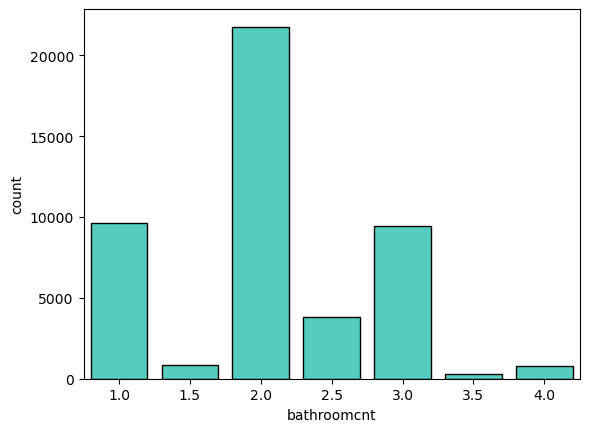

Univariate assessment of feature bedroomcnt:


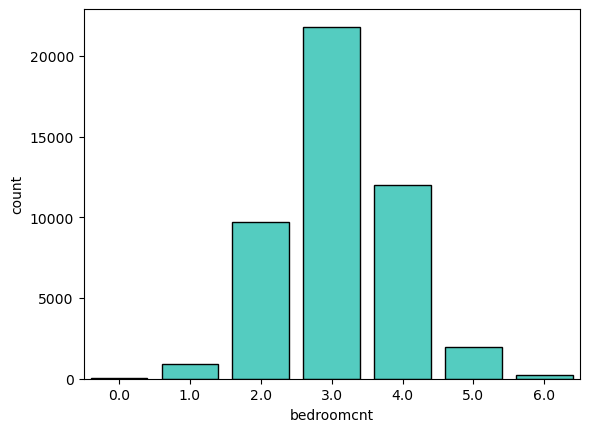

Univariate assessment of feature calculatedbathnbr:


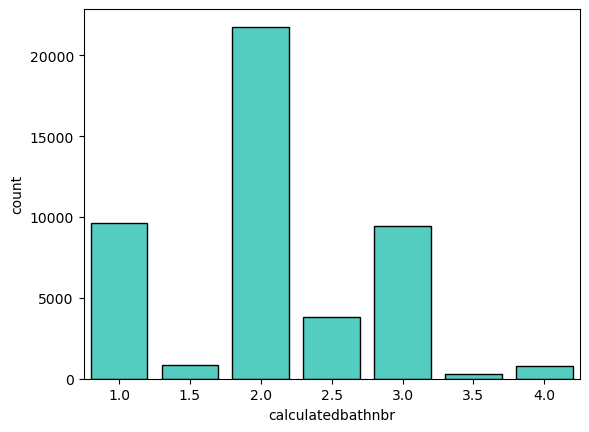

Univariate assessment of feature fips:


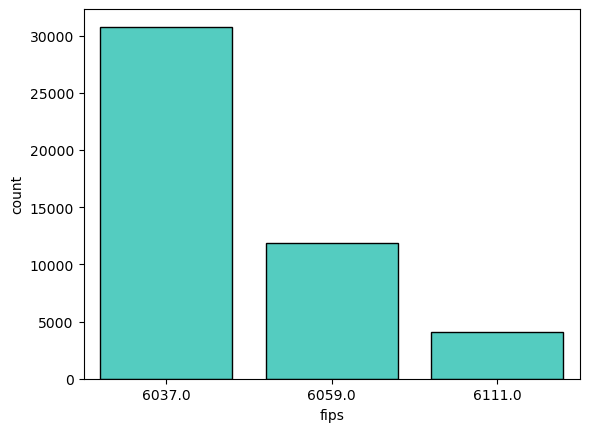

Univariate assessment of feature fullbathcnt:


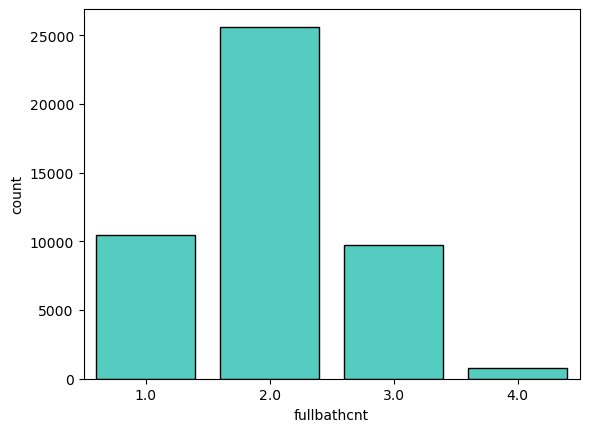

Univariate assessment of feature unitcnt:


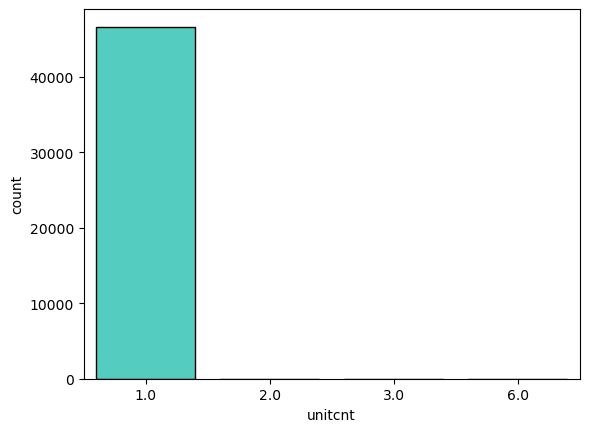

Univariate assessment of feature propertylandusedesc:


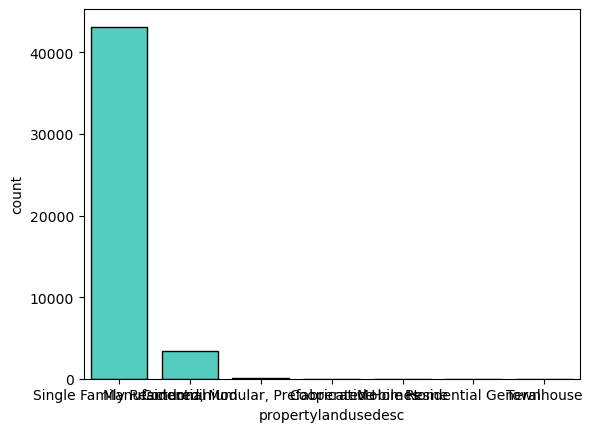

Univariate assessment of feature heatingorsystemdesc:


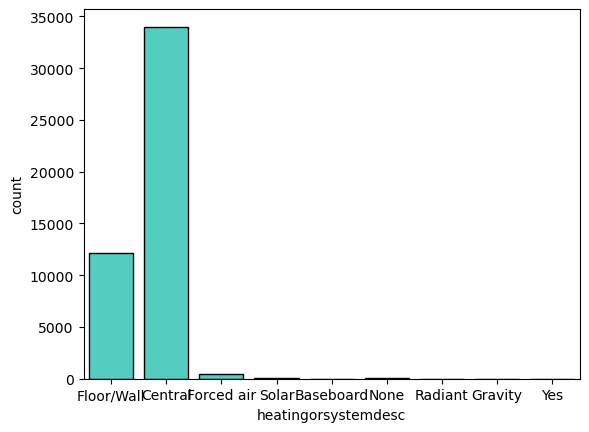

Univariate feature analysis of feature calculatedfinishedsquarefeet: 


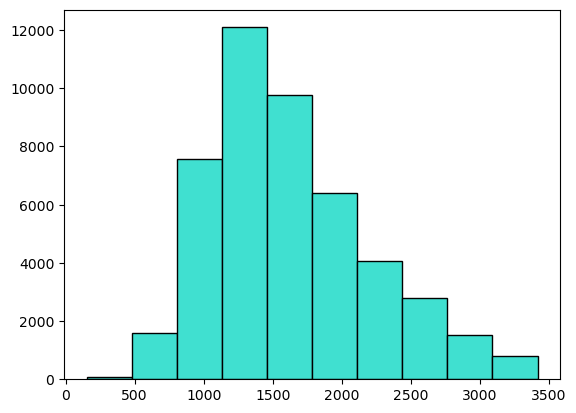

Univariate feature analysis of feature latitude: 


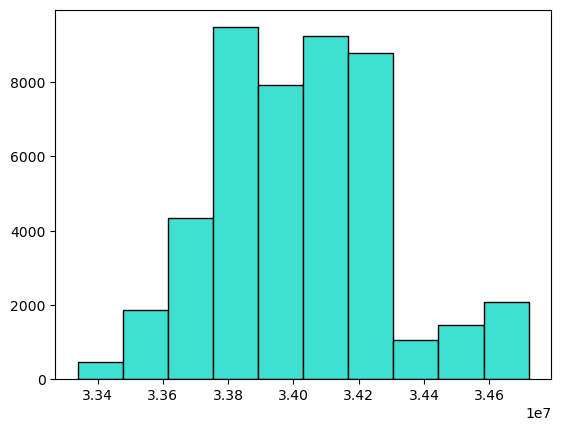

Univariate feature analysis of feature longitude: 


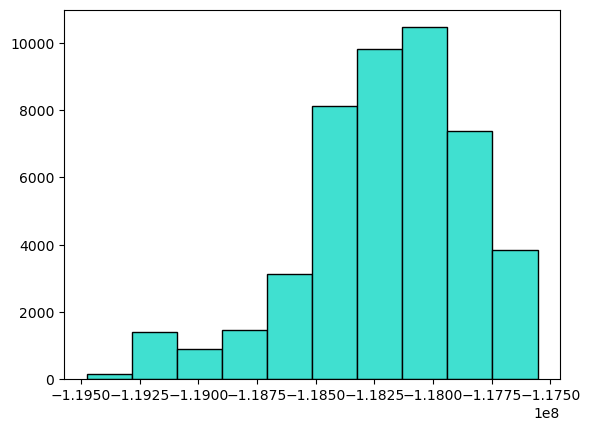

Univariate feature analysis of feature lotsizesquarefeet: 


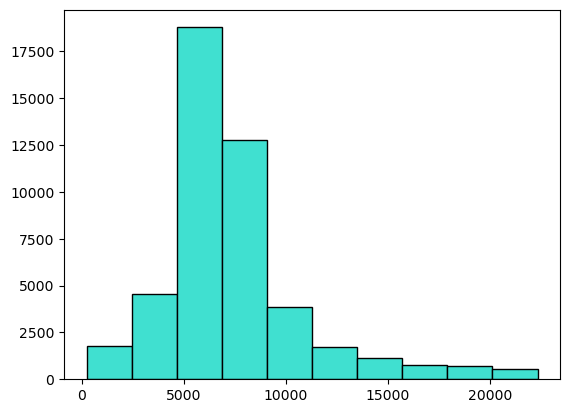

Univariate feature analysis of feature roomcnt: 


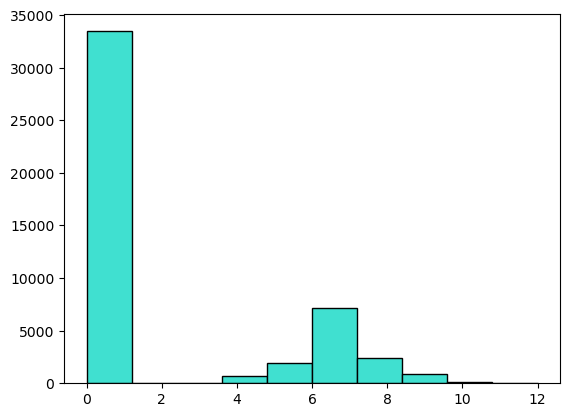

Univariate feature analysis of feature yearbuilt: 


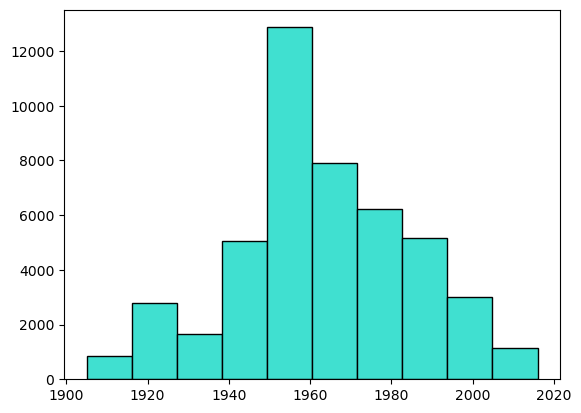

Univariate feature analysis of feature structuretaxvaluedollarcnt: 


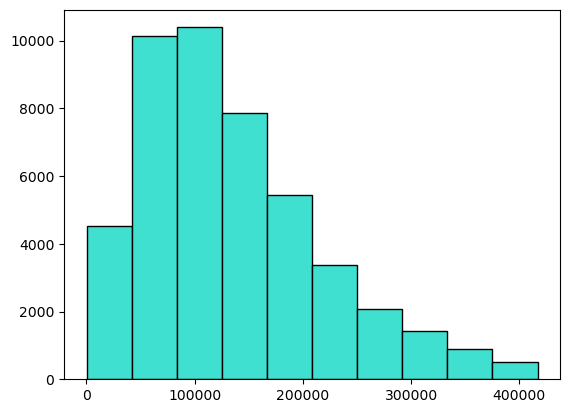

Univariate feature analysis of feature taxvaluedollarcnt: 


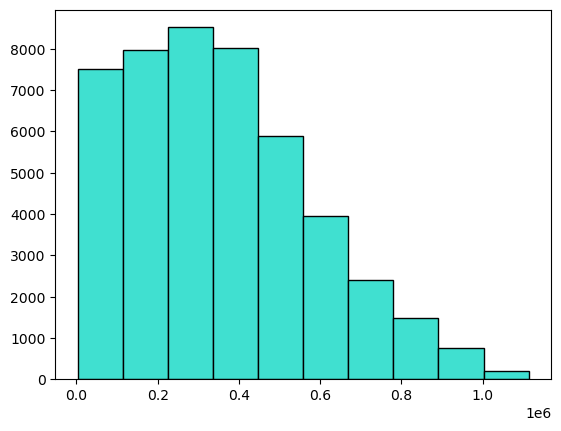

Univariate feature analysis of feature landtaxvaluedollarcnt: 


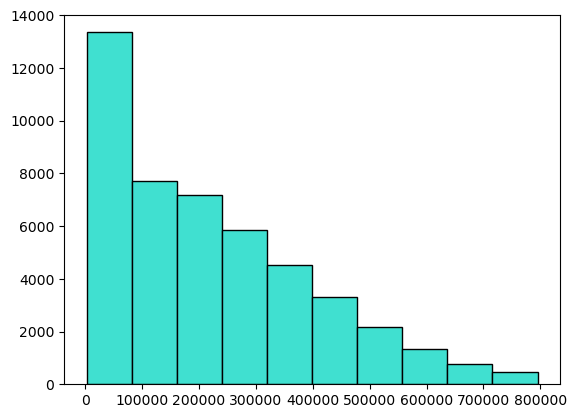

Univariate feature analysis of feature taxamount: 


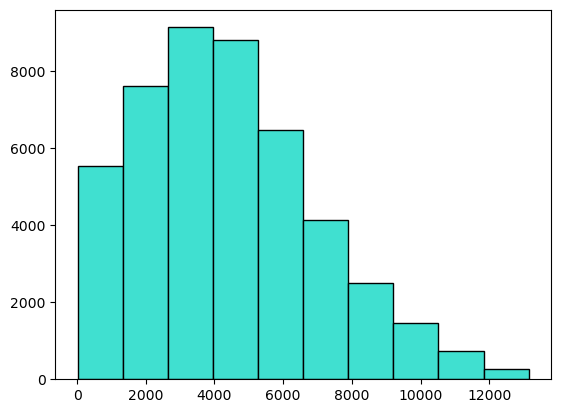

Univariate feature analysis of feature logerror: 


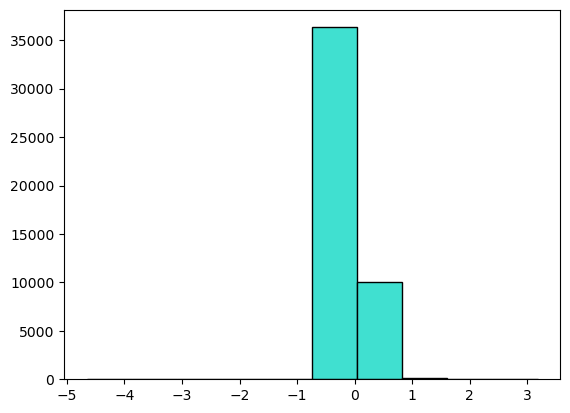

_____________________________________________________
_____________________________________________________

Numeric Columns: ['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'logerror']
Categorical Columns: ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'fips', 'fullbathcnt', 'unitcnt', 'propertylandusedesc', 'heatingorsystemdesc']
Bivariate assessment of feature bathroomcnt:


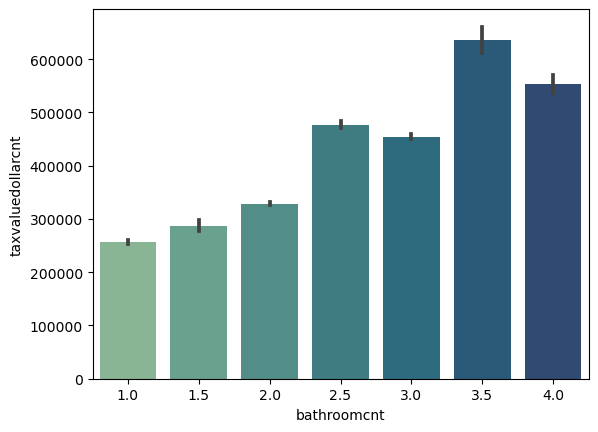

Bivariate assessment of feature bedroomcnt:


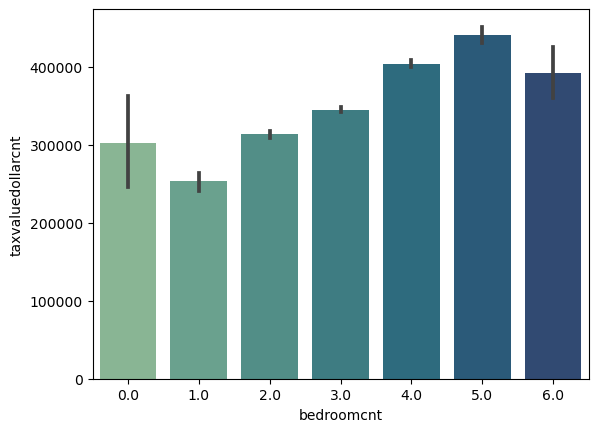

Bivariate assessment of feature calculatedbathnbr:


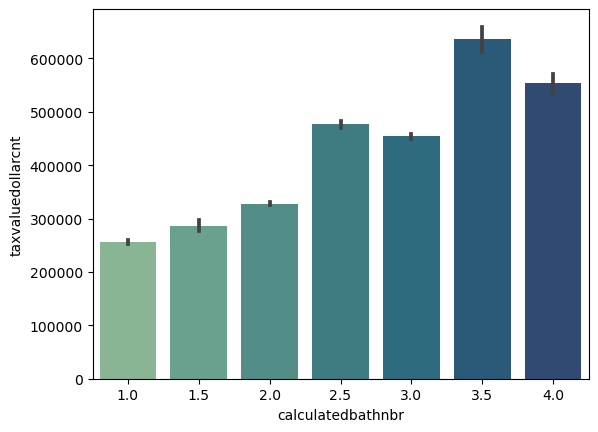

Bivariate assessment of feature fips:


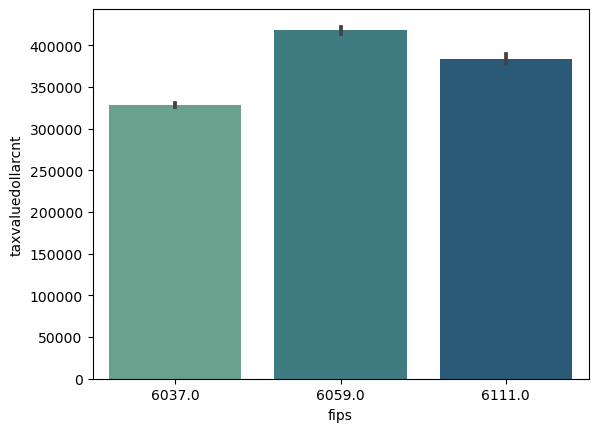

Bivariate assessment of feature fullbathcnt:


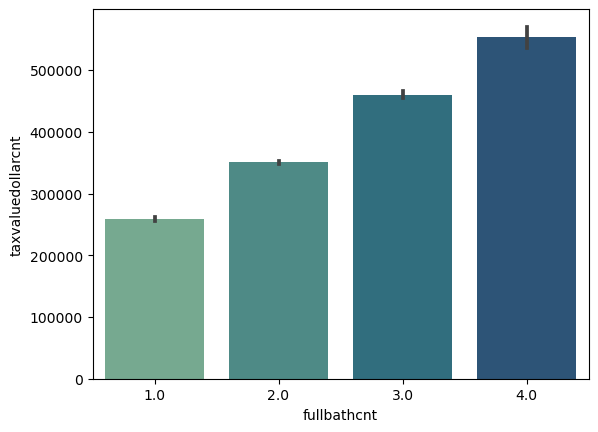

Bivariate assessment of feature unitcnt:


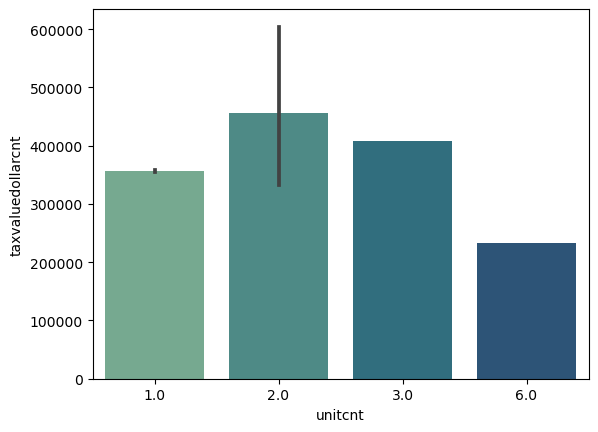

Bivariate assessment of feature propertylandusedesc:


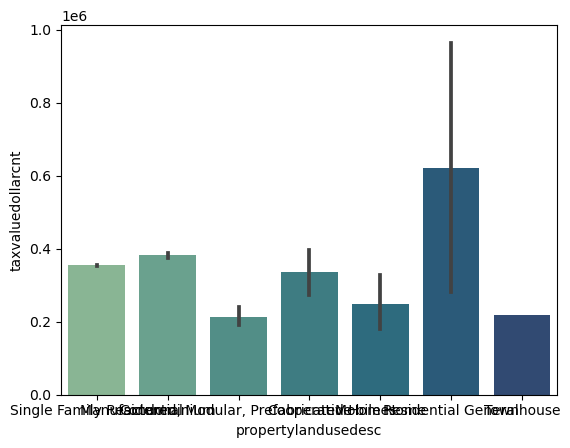

Bivariate assessment of feature heatingorsystemdesc:


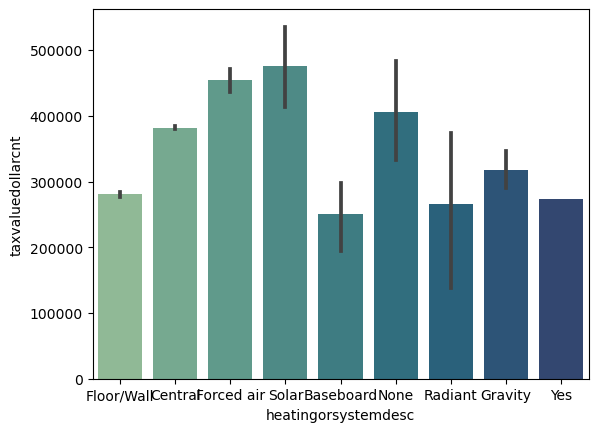

Bivariate feature analysis of feature calculatedfinishedsquarefeet: 


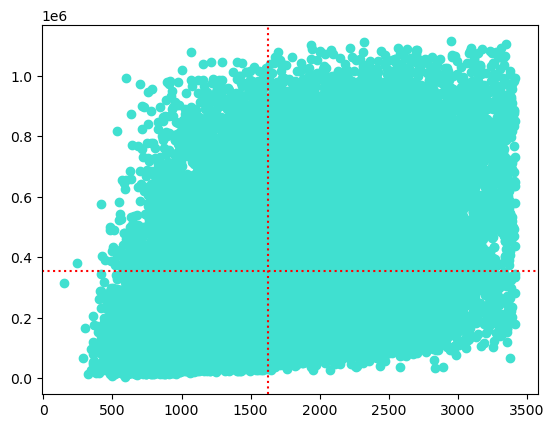

Bivariate feature analysis of feature latitude: 


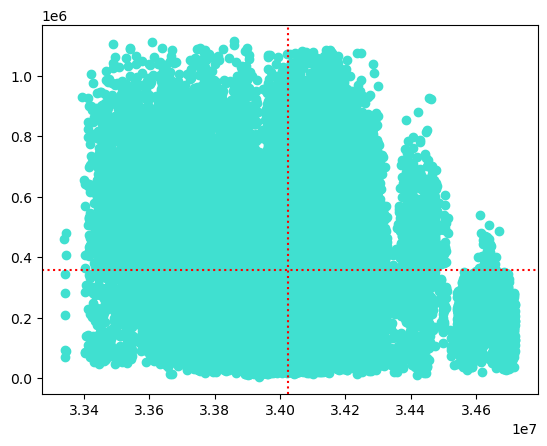

Bivariate feature analysis of feature longitude: 


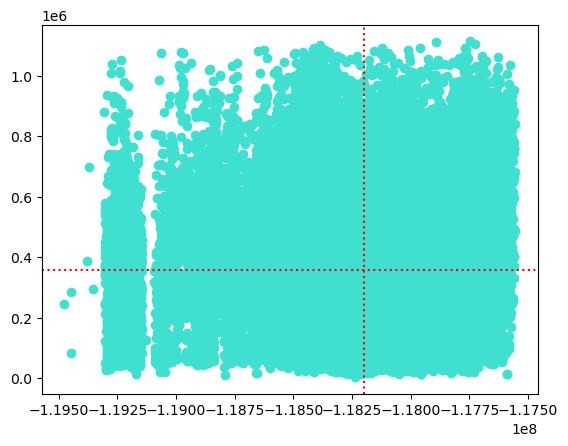

Bivariate feature analysis of feature lotsizesquarefeet: 


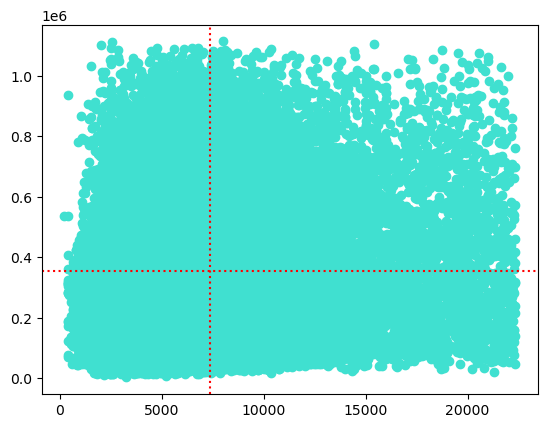

Bivariate feature analysis of feature roomcnt: 


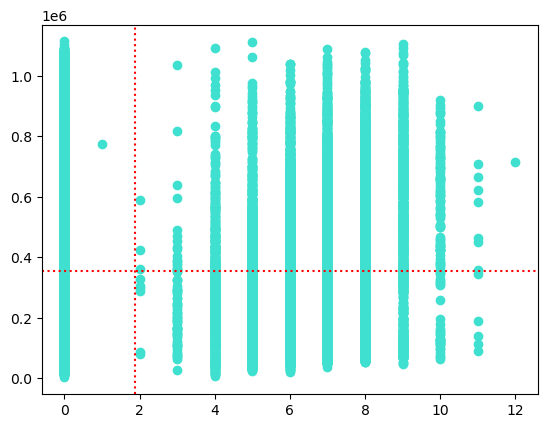

Bivariate feature analysis of feature yearbuilt: 


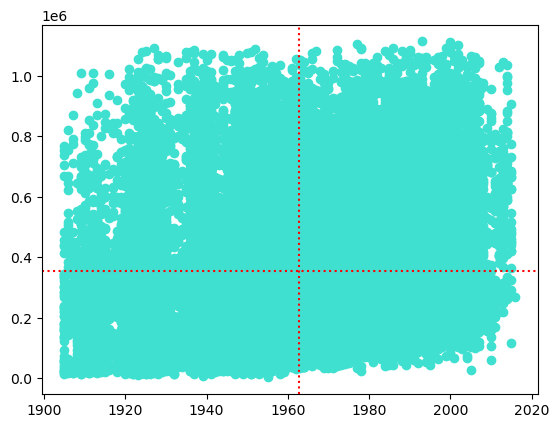

Bivariate feature analysis of feature structuretaxvaluedollarcnt: 


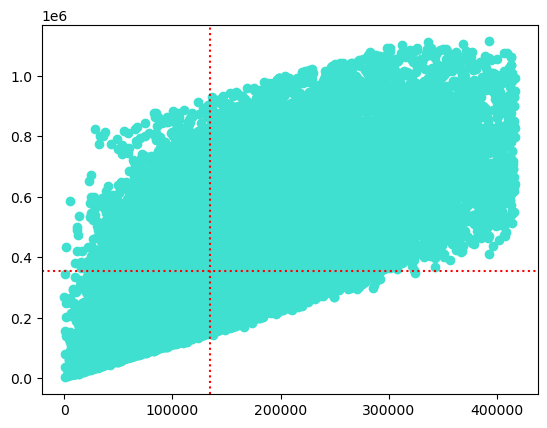

Bivariate feature analysis of feature landtaxvaluedollarcnt: 


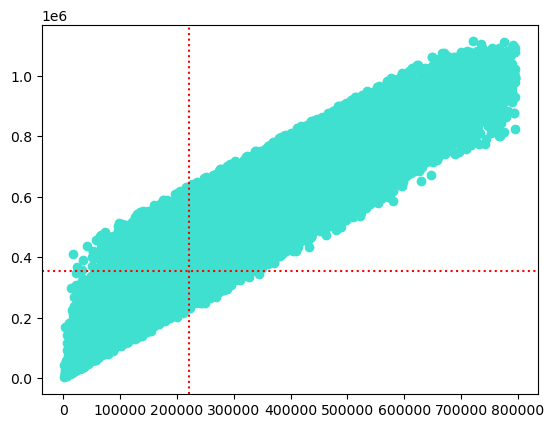

Bivariate feature analysis of feature taxamount: 


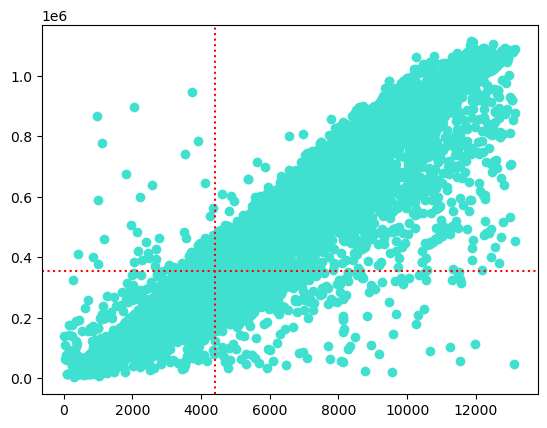

Bivariate feature analysis of feature logerror: 


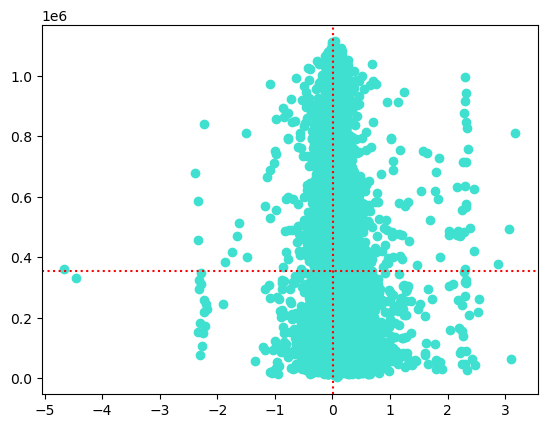

_____________________________________________________
_____________________________________________________

['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror']
['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'lotsizesquarefeet', 'roomcnt', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'logerror']


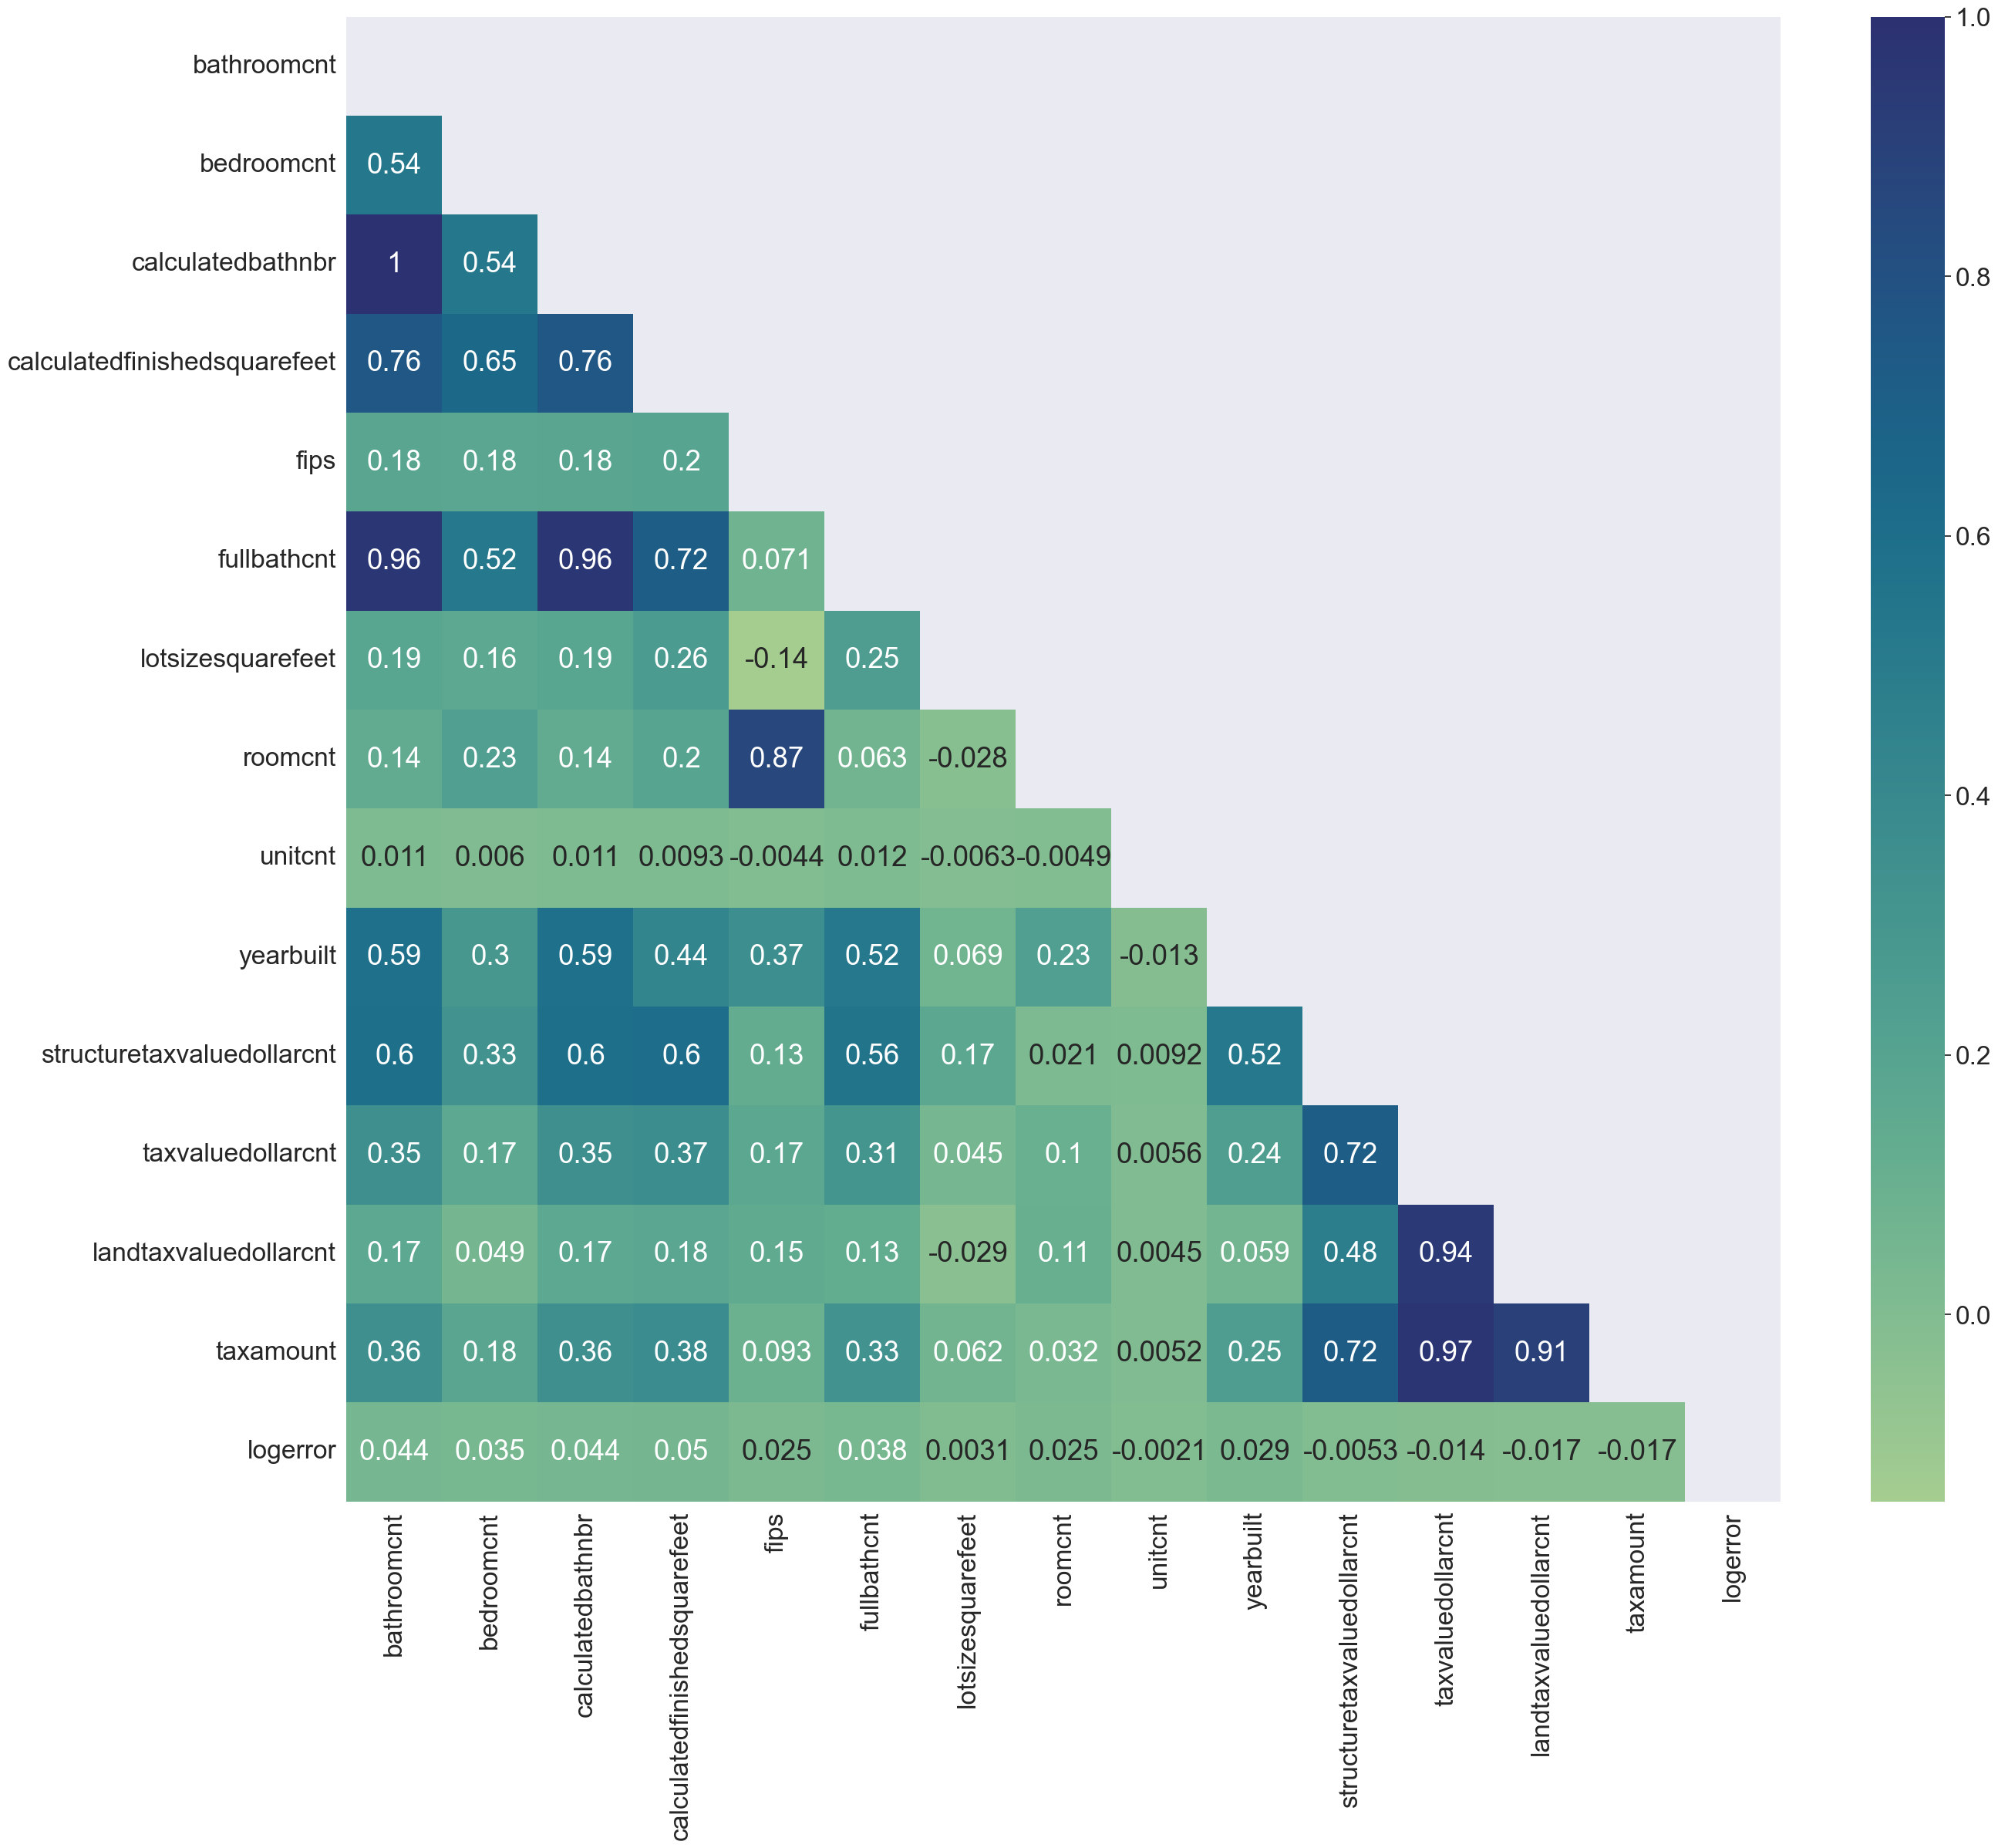

In [36]:
w.viz_explore(df, 'taxvaluedollarcnt')

In [37]:
df['taxvaluedollarcnt'].value_counts()

455,000.00    34
600,000.00    30
450,000.00    29
500,000.00    27
400,000.00    25
              ..
355,445.00     1
401,176.00     1
460,475.00     1
241,391.00     1
564,778.00     1
Name: taxvaluedollarcnt, Length: 33496, dtype: int64

In [38]:
train, validate, test = w.split_data(df)

In [41]:
cat_cols, num_cols = [], []
for col in df.columns:
    if df[col].dtype == "o":
        cat_cols.append(col)
    else:
        if df[col].nunique() < 5:
            cat_cols.append(col)
        else: 
            num_cols.append(col)
num_cols.remove('transactiondate')
num_cols.remove('latitude')
num_cols.remove('longitude')
num_cols.remove('yearbuilt')
num_cols.remove('censustractandblock')
num_cols.remove('propertylandusedesc')
num_cols.remove('heatingorsystemdesc')
num_cols.remove('logerror')

print(num_cols)

train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, columns_to_scale=num_cols)

['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'roomcnt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']


In [44]:
train_scaled.head().T

,56699,17532,53231,44178,11359
bathroomcnt,0.33,0.33,0.00,0.33,0.33
bedroomcnt,0.50,0.50,0.67,0.50,0.50
calculatedbathnbr,0.33,0.33,0.00,0.33,0.33
calculatedfinishedsquarefeet,0.37,0.57,0.31,0.31,0.34
fips,"6,037.00","6,037.00","6,037.00","6,037.00","6,059.00"
fullbathcnt,2.00,2.00,1.00,2.00,2.00
latitude,"33,975,560.00","34,260,252.00","34,119,739.00","34,019,626.00","33,742,607.00"
longitude,"-118,099,687.00","-118,482,483.00","-117,873,436.00","-117,944,987.00","-118,007,400.00"
lotsizesquarefeet,0.22,0.35,0.26,0.24,0.29
roomcnt,0.00,0.00,0.00,0.00,0.50
